# IGF signaling pathway simulations

In [1]:
# Load packages
from MScausality.SCM_numpyro import SCM
from MScausality.simulation import simulate_data
from MScausality.dataProcess import dataProcess

import pandas as pd
import numpy as np
from sklearn import linear_model

import networkx as nx
import y0
from y0.algorithm.simplify_latent import simplify_latent_dag
from y0.algorithm.identify import Identification, identify
from y0.dsl import P, Variable

import pickle
import copy

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

## Build network

In [2]:
def build_igf_network(cell_confounder):
    """
    Create IGF graph in networkx
    
    cell_confounder : bool
        Whether to add in cell type as a confounder
    """
    graph = nx.DiGraph()

    ## Add edges
    graph.add_edge("EGF", "SOS")
    graph.add_edge("EGF", "PI3K")
    graph.add_edge("IGF", "SOS")
    graph.add_edge("IGF", "PI3K")
    graph.add_edge("SOS", "Ras")
    graph.add_edge("Ras", "PI3K")
    graph.add_edge("Ras", "Raf")
    graph.add_edge("PI3K", "Akt")
    graph.add_edge("Akt", "Raf")
    graph.add_edge("Raf", "Mek")
    graph.add_edge("Mek", "Erk")
    
    if cell_confounder:
        graph.add_edge("cell_type", "Ras")
        graph.add_edge("cell_type", "Raf")
        graph.add_edge("cell_type", "Mek")
        graph.add_edge("cell_type", "Erk")
    
    return graph

def build_admg(graph, cell_confounder=False, cell_latent=False):
    ## Define obs vs latent nodes
    all_nodes = ["SOS", "PI3K", "Ras", "Raf", "Akt", 
                 "Mek", "Erk", "EGF", "IGF"]
    obs_nodes = ["SOS", "PI3K", "Ras", "Raf", "Akt", 
                 "Mek", "Erk"]
    latent_nodes = ["EGF", "IGF"]
    
    ## Add in cell_type if included
    if cell_confounder:
        all_nodes.append("cell_type")
        if cell_latent:
            latent_nodes.append("cell_type")
        else:
            obs_nodes.append("cell_type")
        
    attrs = {node: (True if node not in obs_nodes and 
                    node != "\\n" else False) for node in all_nodes}

    nx.set_node_attributes(graph, attrs, name="hidden")
    
    ## Use y0 to build ADMG
    simplified_graph = simplify_latent_dag(graph.copy(), "hidden")
    y0_graph = y0.graph.NxMixedGraph()
    y0_graph = y0_graph.from_latent_variable_dag(graph, "hidden")
    
    return y0_graph

In [3]:
cell_type_graph = build_igf_network(cell_confounder=True)
bulk_graph = build_igf_network(cell_confounder=False)
y0_graph_bulk = build_admg(bulk_graph, cell_confounder=False)

/tmp/ipykernel_4691/1518289386.py:25: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(temp_g, pos=pos, ax=ax, connectionstyle='arc3, rad = 0.1',


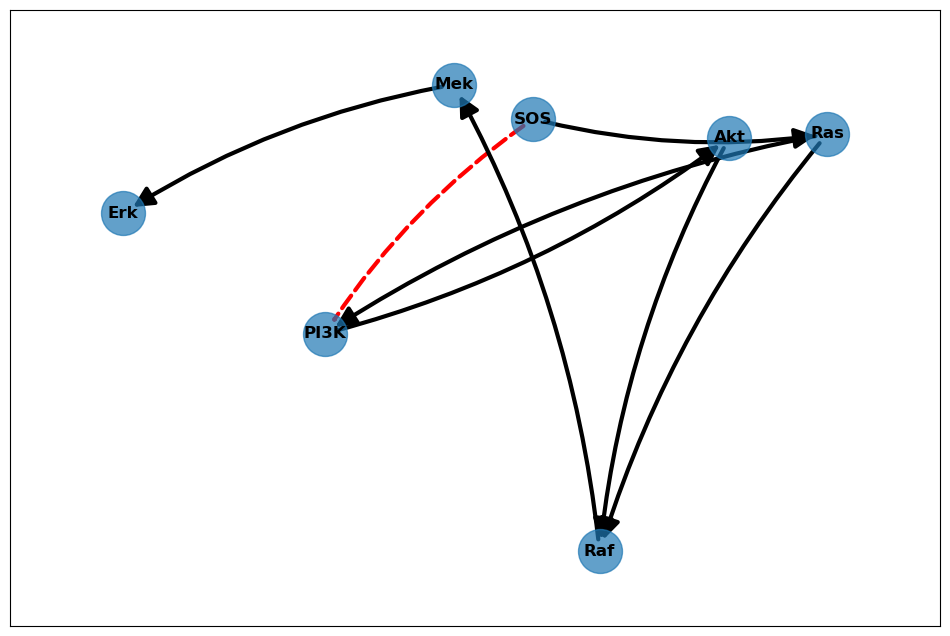

In [7]:
def plot_latent_graph(y0_graph, figure_size=(4, 3), title=None):

    ## Create new graph and specify color and shape of observed vs latent edges
    temp_g = nx.DiGraph()

    for d_edge in list(y0_graph.directed.edges):
        temp_g.add_edge(d_edge[0], d_edge[1], color="black", style='-', size=30)
    for u_edge in list(y0_graph.undirected.edges):
        if temp_g.has_edge(u_edge[0], u_edge[1]):
            temp_g.add_edge(u_edge[1], u_edge[0], color="red", style='--', size=1)
        else:
            temp_g.add_edge(u_edge[0], u_edge[1], color="red", style='--', size=1)

    ## Extract edge attributes
    pos = nx.random_layout(temp_g)
    edges = temp_g.edges()
    colors = [temp_g[u][v]['color'] for u, v in edges]
    styles = [temp_g[u][v]['style'] for u, v in edges]
    arrowsizes = [temp_g[u][v]['size'] for u, v in edges]

    ## Plot
    fig, ax = plt.subplots(figsize=figure_size)
    nx.draw_networkx_nodes(temp_g, pos=pos, node_size=1000, margins=[.1, .1], alpha=.7)
    nx.draw_networkx_labels(temp_g, pos=pos, font_weight='bold')
    nx.draw_networkx_edges(temp_g, pos=pos, ax=ax, connectionstyle='arc3, rad = 0.1',
                           edge_color=colors, width=3, style=styles, arrowsize=arrowsizes)
    if title is not None:
        ax.set_title(title)
    plt.show()
    
plot_latent_graph(y0_graph_bulk, figure_size=(12, 8))

## Ground truth invervention

Generate interventional data using the ground truth network for comparison.

In [4]:
## Coefficients for relations
cell_coef = {'EGF': {'intercept': 18., "error": 3},
              'IGF': {'intercept': 17., "error": 3},
              'SOS': {'intercept': -4, "error": 1, 
                      'EGF': 0.6, 'IGF': 0.6,},
              'Ras': {'intercept': 5, "error": 1, 'SOS': .5, "cell_type" : [3, 0, -3]},
              'PI3K': {'intercept': 1.6, "error": 1, 
                       'EGF': .5, 'IGF': 0.5, 'Ras': .5,},
              'Akt': {'intercept': 2., "error": 1, 'PI3K': 0.75, },
              'Raf': {'intercept': 2, "error": 1,
                      'Ras': 0.8, 'Akt': -.4, "cell_type" : [-2, 0, 2]},
              'Mek': {'intercept': 3., "error": 1, 'Raf': 0.75, "cell_type" : [-2, 0, 2]},
              'Erk': {'intercept': 4., "error": 1, 'Mek': 1.2, "cell_type" : [-2, 0, 2]}
             }

In [5]:
def obs_gt_sim(coef, n, cell_type, n_cells=1):
    
    """
    Observational ground truth simulation of network
    """
    
    if cell_type:
        cell_type = np.repeat([i for i in range(n_cells)], n//n_cells)
        if len(cell_type) < n:
            cell_type = np.append(cell_type, n_cells-1)
            
    EGF = np.random.normal(coef["EGF"]["intercept"], 3, n)
    IGF = np.random.normal(coef["IGF"]["intercept"], 3, n)

    SOS = coef["SOS"]["intercept"] + coef["SOS"]["EGF"]*EGF + coef["SOS"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Ras = coef["Ras"]["intercept"] + coef["Ras"]["SOS"]*SOS + np.array(coef["Ras"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    PI3K = coef["PI3K"]["intercept"] + coef["PI3K"]["Ras"]*Ras + coef["PI3K"]["EGF"]*EGF + coef["PI3K"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Akt = coef["Akt"]["intercept"] + coef["Akt"]["PI3K"]*PI3K + np.random.normal(0, 1., n)
    Raf = coef["Raf"]["intercept"] + coef["Raf"]["Ras"]*Ras + coef["Raf"]["Akt"]*Akt + np.array(coef["Raf"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    Mek = coef["Mek"]["intercept"] + coef["Mek"]["Raf"]*Raf + np.array(coef["Mek"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    Erk = coef["Erk"]["intercept"] + coef["Erk"]["Mek"]*Mek + np.array(coef["Erk"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    
    return({"EGF" : EGF, "IGF" : IGF, "SOS" : SOS, 
            "Ras" : Ras, "PI3K": PI3K, "Akt" : Akt,
            "Raf" : Raf, "Mek" : Mek, "Erk" : Erk, "cell_type" : cell_type})

def int_gt_sim(coef, n, inc_cell_type, n_cells=1):

    """
    Ras interventional simulation of network (Ras=10 vs Ras=20)
    """
    
    if inc_cell_type:
        cell_type = np.repeat([i for i in range(n_cells)], n//n_cells)
        if len(cell_type) < n:
            cell_type = np.append(cell_type, n_cells-1)
            
    EGF = np.random.normal(coef["EGF"]["intercept"], 3, n)
    IGF = np.random.normal(coef["IGF"]["intercept"], 3, n)

    SOS = coef["SOS"]["intercept"] + coef["SOS"]["EGF"]*EGF + coef["SOS"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Ras = 10
    PI3K = coef["PI3K"]["intercept"] + coef["PI3K"]["Ras"]*Ras + coef["PI3K"]["EGF"]*EGF + coef["PI3K"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Akt = coef["Akt"]["intercept"] + coef["Akt"]["PI3K"]*PI3K + np.random.normal(0, 1., n)
    Raf = coef["Raf"]["intercept"] + coef["Raf"]["Ras"]*Ras + coef["Raf"]["Akt"]*Akt + np.array(coef["Raf"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    Mek = coef["Mek"]["intercept"] + coef["Mek"]["Raf"]*Raf + np.array(coef["Mek"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    Erk10 = coef["Erk"]["intercept"] + coef["Erk"]["Mek"]*Mek + np.array(coef["Erk"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    
    EGF = np.random.normal(coef["EGF"]["intercept"], 5, n)
    IGF = np.random.normal(coef["IGF"]["intercept"], 5, n)

    SOS = coef["SOS"]["intercept"] + coef["SOS"]["EGF"]*EGF + coef["SOS"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Ras = 20
    PI3K = coef["PI3K"]["intercept"] + coef["PI3K"]["Ras"]*Ras + coef["PI3K"]["EGF"]*EGF + coef["PI3K"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Akt = coef["Akt"]["intercept"] + coef["Akt"]["PI3K"]*PI3K + np.random.normal(0, 1., n)
    Raf = coef["Raf"]["intercept"] + coef["Raf"]["Ras"]*Ras + coef["Raf"]["Akt"]*Akt + np.array(coef["Raf"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    Mek = coef["Mek"]["intercept"] + coef["Mek"]["Raf"]*Raf + np.array(coef["Mek"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    Erk20 = coef["Erk"]["intercept"] + coef["Erk"]["Mek"]*Mek + np.array(coef["Erk"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    
    int_data = [Erk10, Erk20]
    if inc_cell_type:
        int_data.append(cell_type)
        
    return int_data

gt_int_cell = int_gt_sim(cell_coef, 100000, inc_cell_type=True, n_cells=3)

(-5.0, 30.0)

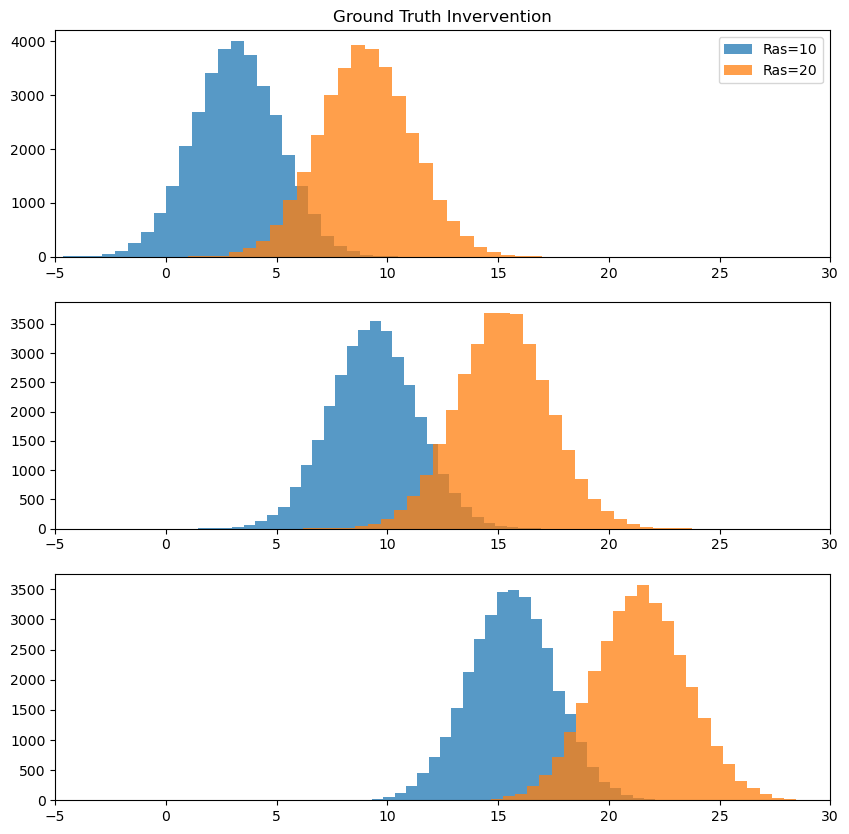

In [6]:
fig, ax = plt.subplots(3,1,figsize=(10,10))

ax[0].hist(gt_int_cell[0][gt_int_cell[2] == 0], label="Ras=10", alpha=.75, bins=30)
ax[0].hist(gt_int_cell[1][gt_int_cell[2] == 0], label="Ras=20", alpha=.75, bins=30)
ax[0].legend()
ax[1].hist(gt_int_cell[0][gt_int_cell[2] == 1], label="Ras=10", alpha=.75, bins=30)
ax[1].hist(gt_int_cell[1][gt_int_cell[2] == 1], label="Ras=20", alpha=.75, bins=30)
ax[2].hist(gt_int_cell[0][gt_int_cell[2] == 2], label="Ras=10", alpha=.75, bins=30)
ax[2].hist(gt_int_cell[1][gt_int_cell[2] == 2], label="Ras=20", alpha=.75, bins=30)

ax[0].set_title("Ground Truth Invervention")
ax[0].set_xlim(-5, 30)
ax[1].set_xlim(-5, 30)
ax[2].set_xlim(-5, 30)

In [15]:
np.mean(gt_int_cell[1][gt_int_cell[2] == 0]) - np.mean(gt_int_cell[0][gt_int_cell[2] == 0])

5.851975251872332

In [16]:
np.mean(gt_int_cell[1][gt_int_cell[2] == 1]) - np.mean(gt_int_cell[0][gt_int_cell[2] == 1])

5.838004229285987

In [17]:
np.mean(gt_int_cell[1][gt_int_cell[2] == 2]) - np.mean(gt_int_cell[0][gt_int_cell[2] == 2])

5.864227263194335

(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500., 4000.,
        4500.]),
 [Text(0, 0.0, '0'),
  Text(0, 500.0, '500'),
  Text(0, 1000.0, '1000'),
  Text(0, 1500.0, '1500'),
  Text(0, 2000.0, '2000'),
  Text(0, 2500.0, '2500'),
  Text(0, 3000.0, '3000'),
  Text(0, 3500.0, '3500'),
  Text(0, 4000.0, '4000'),
  Text(0, 4500.0, '4500')])

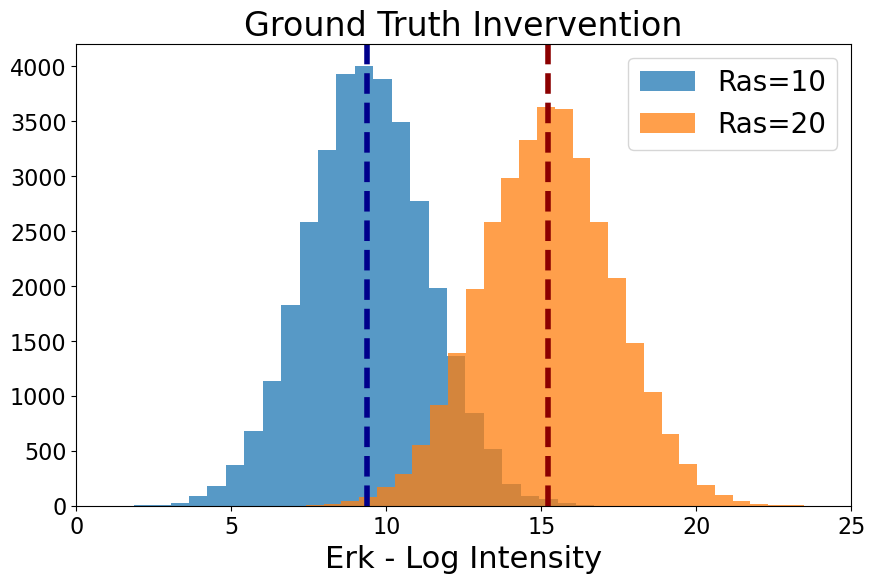

In [22]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(gt_int_cell[0][gt_int_cell[2] == 1], label="Ras=10", alpha=.75, bins=30)
ax.axvline(np.mean(np.array(gt_int_cell[0][gt_int_cell[2] == 1])), color="darkblue", linestyle="dashed", lw=4)
ax.hist(gt_int_cell[1][gt_int_cell[2] == 1], label="Ras=20", alpha=.75, bins=30)
ax.axvline(np.mean(np.array(gt_int_cell[1][gt_int_cell[2] == 1])), color="darkred", linestyle="dashed", lw=4)
ax.legend(fontsize=20)

ax.set_title("Ground Truth Invervention", size=24)
ax.set_xlim(0, 25)
ax.set_xlabel("Erk - Log Intensity", size=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

## Cell Type - Bulk

### Simulate Data

In [7]:
cell_sim = simulate_data(bulk_graph, coefficients=cell_coef, include_missing=True, 
                         cell_type=True, n_cells=3, n=300, seed=1)

simulating data...
adding feature level data...


/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:200: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_level_data = pd.concat([feature_level_data, pd.DataFrame({"Protein": [node],
/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:200: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_level_data = pd.con

masking data...


/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:239: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_level_data.loc[i, "MAR"] = False
/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:245: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_level_data.loc[i, "MNAR"] = False


Save feature level data to csvs to run data processing in MSstats in R. Wrapper for dataProcess functionality is being added to MScausality but is not currently available. For information on the R code to run please see the documentation for the dataProcess.py function (i.e., ?dataProcess)

In [9]:
?dataProcess

Signature: dataProcess(data, normalization='equalizeMedians', MBimpute=True)
Docstring:
Implementation of MSstats dataProcess function in Python.

Currently unavailable, to convert simualated data into MSstats format and run dataProcess function,
execute the following code in R:

library(MSstats)
library(tidyverse)

data = read.csv("sim_feature_level_data.csv")
data = data %>% select(Protein, Feature, Replicate, Obs_Intensity)
data = data %>% rename(ProteinName=Protein, PeptideSequence=Feature,
                       BioReplicate=Replicate, Intensity=Obs_Intensity)

data$PrecursorCharge = 2
data$FragmentIon = NA
data$ProductCharge= NA
data$IsotopeLabelType = "L"
data$Condition = "Obs"
data$Run = data$BioReplicate
data$Fraction = 1
data$PeptideSequence  = paste(data$ProteinName, data$PeptideSequence , sep="_")
data$Run = paste(data$Run, data$Condition, sep="_")
data$Intensity = 2**data$Intensity

processed_data = dataProcess(data, normalization="equalizeMedians", MBimpute=TRUE)
processe

In [111]:
cell_sim["Feature_data"].to_csv("../data/IGF_pathway/cell_type_feature_data.csv", index=False)

In [8]:
cell_sim_protein_data = pd.read_csv("../data/IGF_pathway/cell_type_protein_data.csv")
cell_sim_protein_data.loc[:, "cell_type"] = cell_sim["Protein_data"]["cell_type"].astype(str)

### Initial Analysis

(array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 [Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4'),
  Text(0, 5.0, '5'),
  Text(0, 6.0, '6'),
  Text(0, 7.0, '7'),
  Text(0, 8.0, '8'),
  Text(0, 9.0, '9'),
  Text(0, 10.0, '10'),
  Text(0, 11.0, '11')])

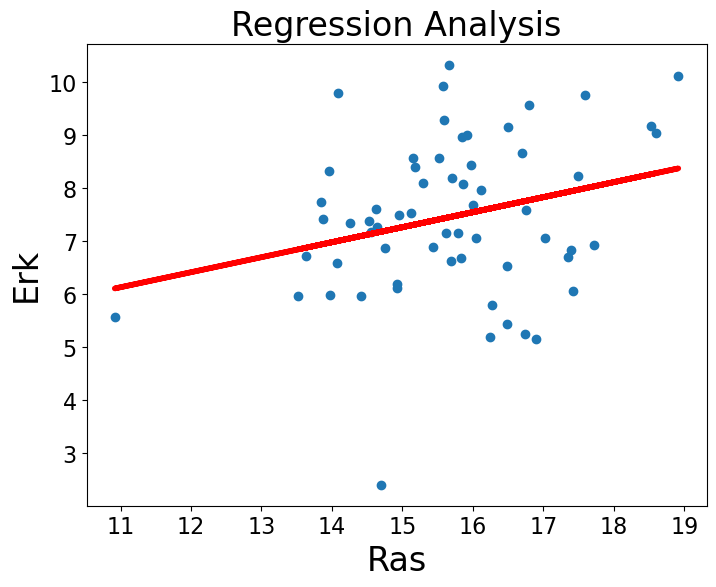

In [116]:
fig, ax = plt.subplots(figsize=(8,6))

plot_data = cell_sim_protein_data.dropna()
x = plot_data[plot_data["cell_type"] == "0"]["Ras"]
y = plot_data[plot_data["cell_type"] == "0"]["Erk"]

ax.scatter(x, y)
m, b = np.polyfit(x.values, y.values, 1)
ax.plot(x, m*x + b, color="red", lw=4)

ax.set_title("Regression Analysis", size=24)
ax.set_xlabel("Ras", size=24)
ax.set_ylabel("Erk", size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

(array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5]),
 [Text(0, 0.0, '0.0'),
  Text(0, 2.5, '2.5'),
  Text(0, 5.0, '5.0'),
  Text(0, 7.5, '7.5'),
  Text(0, 10.0, '10.0'),
  Text(0, 12.5, '12.5'),
  Text(0, 15.0, '15.0'),
  Text(0, 17.5, '17.5'),
  Text(0, 20.0, '20.0'),
  Text(0, 22.5, '22.5')])

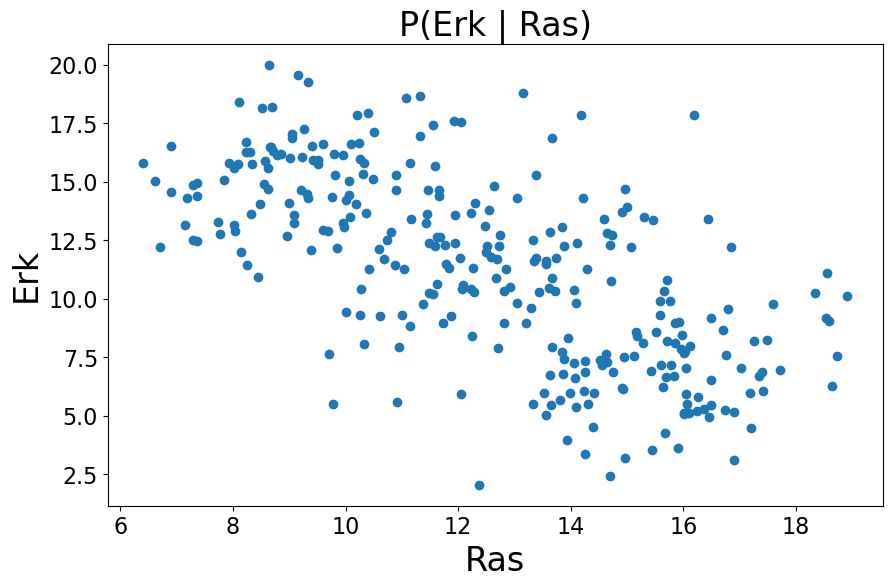

In [117]:
fig, ax = plt.subplots(figsize=(10,6))

x = cell_sim_protein_data["Ras"]
y = cell_sim_protein_data["Erk"]

ax.scatter(x, y)

ax.set_title("P(Erk | Ras)", size=24)
ax.set_xlabel("Ras", size=24)
ax.set_ylabel("Erk", size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

### Run inference

In [21]:
scm = SCM(cell_sim_protein_data.iloc[:,1:-1], y0_graph_bulk)
scm.prepare_scm_input()
scm.fit_scm(num_samples=1000, warmup_steps=4000, num_chains=4)

scm.intervention("Ras", "Erk", 10)
first_int = scm.intervention_samples

scm.intervention("Ras", "Erk", 20)
second_int = scm.intervention_samples

Finding root nodes...
Adding latent confounders to graph...
Determining missing obs...
Running MCMC...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [134]:
scm.summary_stats

{'Akt_PI3K_coef': OrderedDict([('mean', 0.7542848),
              ('std', 0.026954724),
              ('median', 0.7585183),
              ('5.0%', 0.7064711),
              ('95.0%', 0.79915804),
              ('n_eff', 150.65304105179032),
              ('r_hat', 1.026493578289877)]),
 'Akt_intercept': OrderedDict([('mean', 1.8664734),
              ('std', 0.6811156),
              ('median', 1.8375188),
              ('5.0%', 0.7032434),
              ('95.0%', 3.0415144),
              ('n_eff', 169.20673115101766),
              ('r_hat', 1.0217753393263178)]),
 'Akt_scale': OrderedDict([('mean', 1.0262662),
              ('std', 0.06840365),
              ('median', 1.0133795),
              ('5.0%', 0.9315871),
              ('95.0%', 1.1416193),
              ('n_eff', 19.691083551061094),
              ('r_hat', 1.0907581359517424)]),
 'Erk_Mek_coef': OrderedDict([('mean', 1.7639937),
              ('std', 0.063249536),
              ('median', 1.7642694),
              ('5.0

In [25]:
np.mean(np.array(second_int)) - np.mean(np.array(first_int))

1.3010406

(-5.0, 40.0)

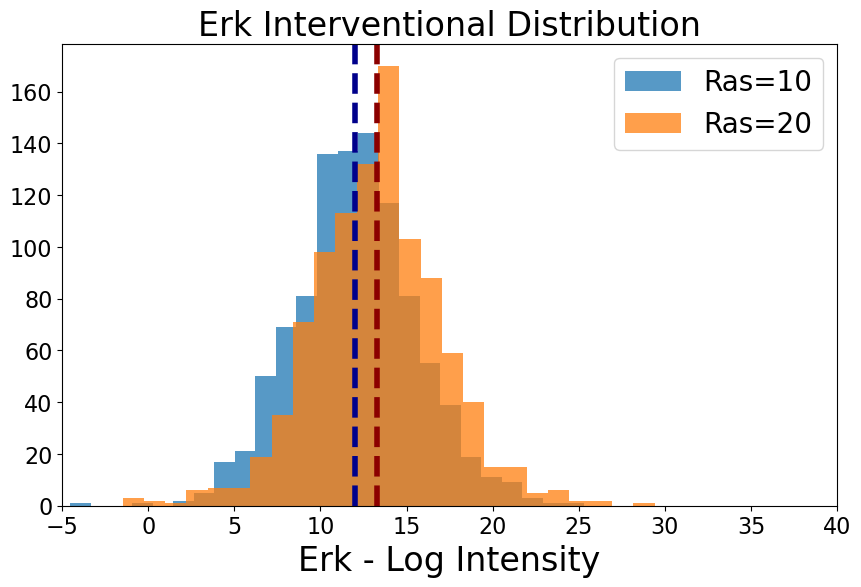

In [35]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(np.array(first_int), bins=25, alpha=.75, label="Ras=10")
ax.axvline(np.mean(np.array(first_int)), color="darkblue", linestyle="dashed", lw=4)
ax.hist(np.array(second_int), bins=25, alpha=.75, label="Ras=20")
ax.axvline(np.mean(np.array(second_int)), color="darkred", linestyle="dashed", lw=4)

ax.legend(fontsize=20)
ax.set_title("Erk Interventional Distribution", size=24)
ax.set_xlabel("Erk - Log Intensity", size=24)
# ax.set_ylabel("Erk", size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax.set_xlim(-5,40)

## Cell Type - Single cell

### Analysis

In [18]:
single_cell_lm = linear_model.LinearRegression()

fit_data = pd.concat([cell_sim_protein_data[["Ras", "Erk"]], 
               pd.get_dummies(cell_sim_protein_data["cell_type"].values)], 
              axis=1).dropna()
x = fit_data.drop(columns=["Erk"])
y = fit_data["Erk"]
single_cell_lm.fit(x, y)

bulk_lm = linear_model.LinearRegression()
x = cell_sim_protein_data.dropna()[["Ras"]]
y = cell_sim_protein_data.dropna()[["Erk"]]
bulk_lm.fit(x, y)

LinearRegression()

Text(0, 0.5, 'Erk')

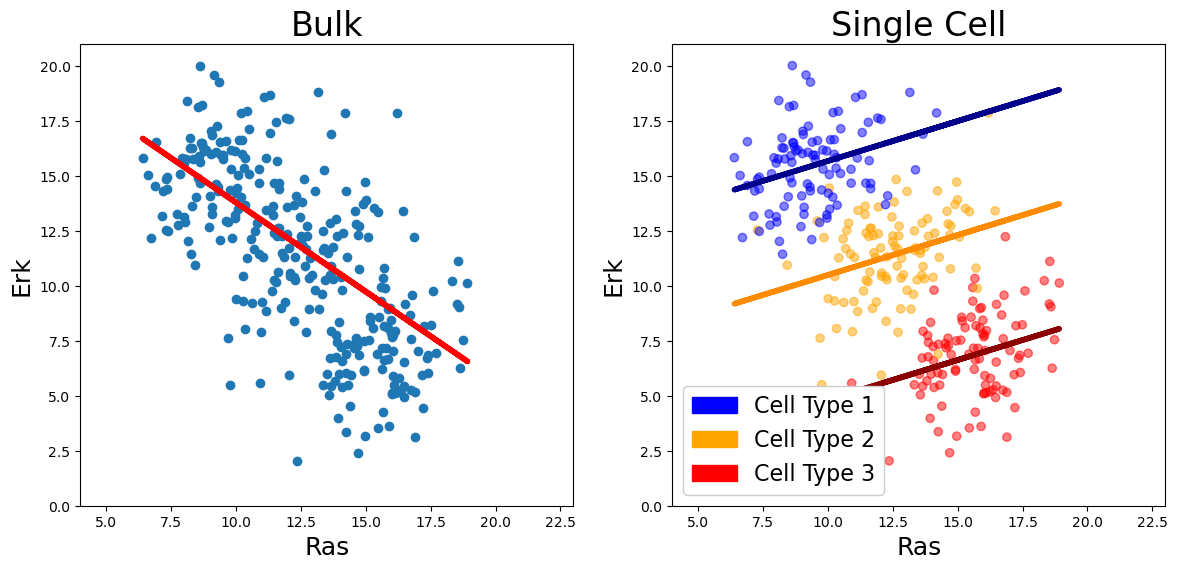

In [19]:
## Plot
fig, ax = plt.subplots(1, 2, figsize=(14,6))

colors = np.where(cell_sim_protein_data["cell_type"] == "0", "Red", 
                  np.where(cell_sim_protein_data["cell_type"] == "1", "Orange", "Blue"))

ax[0].scatter(cell_sim_protein_data["Ras"], cell_sim_protein_data["Erk"])
ax[1].scatter(cell_sim_protein_data["Ras"], cell_sim_protein_data["Erk"], 
              c=colors, alpha=.5)

ax[0].plot(cell_sim_protein_data["Ras"], 
           bulk_lm.coef_[0]*cell_sim_protein_data["Ras"] + bulk_lm.intercept_[0], 
           color="red", lw=4)
ax[1].plot(cell_sim_protein_data["Ras"], 
           single_cell_lm.coef_[0]*cell_sim_protein_data["Ras"] + \
           single_cell_lm.intercept_ + single_cell_lm.coef_[1], 
           color="darkred", lw=4)
ax[1].plot(cell_sim_protein_data["Ras"], 
           single_cell_lm.coef_[0]*cell_sim_protein_data["Ras"] + \
           single_cell_lm.intercept_ + single_cell_lm.coef_[2], 
           color="darkOrange", lw=4)
ax[1].plot(cell_sim_protein_data["Ras"], 
           single_cell_lm.coef_[0]*cell_sim_protein_data["Ras"] + \
           single_cell_lm.intercept_ + single_cell_lm.coef_[3], 
           color="darkBlue", lw=4)

red_patch = mpatches.Patch(color='red', label='Cell Type 3')
orange_patch = mpatches.Patch(color='orange', label='Cell Type 2')
blue_patch = mpatches.Patch(color='blue', label='Cell Type 1')

ax[1].legend(handles=[blue_patch, orange_patch, red_patch], fontsize=16, loc="lower left", framealpha=1.)

ax[0].set_xlim(4,23)
ax[1].set_xlim(4,23)
ax[0].set_ylim(0,21)
ax[1].set_ylim(0,21)

ax[0].set_title("Bulk", fontsize=24)
ax[1].set_title("Single Cell", fontsize=24)

ax[0].set_xlabel("Ras", fontsize=18)
ax[1].set_xlabel("Ras", fontsize=18)

ax[0].set_ylabel("Erk", fontsize=18)
ax[1].set_ylabel("Erk", fontsize=18)

# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)

### Run inference

In [37]:
datasets = {"Cell1" : cell_sim_protein_data[cell_sim_protein_data["cell_type"] == "0"].iloc[:,1:-1], 
            "Cell2" : cell_sim_protein_data[cell_sim_protein_data["cell_type"] == "1"].iloc[:,1:-1],
            "Cell3" : cell_sim_protein_data[cell_sim_protein_data["cell_type"] == "2"].iloc[:,1:-1]}

intervention_results = dict()

for name, data in datasets.items():
    scm = SCM(data, y0_graph_bulk)
    scm.prepare_scm_input()
    scm.fit_scm(num_samples=1000, warmup_steps=4000, num_chains=4)
    
    scm.intervention("Ras", "Erk", 10, n=1000)
    first_int = scm.intervention_samples
    
    scm.intervention("Ras", "Erk", 20, n=1000)
    second_int = scm.intervention_samples
    
    intervention_results[name] = [first_int, second_int, scm]

Finding root nodes...
Adding latent confounders to graph...
Determining missing obs...
Running MCMC...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Finding root nodes...
Adding latent confounders to graph...
Determining missing obs...
Running MCMC...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Finding root nodes...
Adding latent confounders to graph...
Determining missing obs...
Running MCMC...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Text(0.5, 0, 'Erk - Log Intensity')

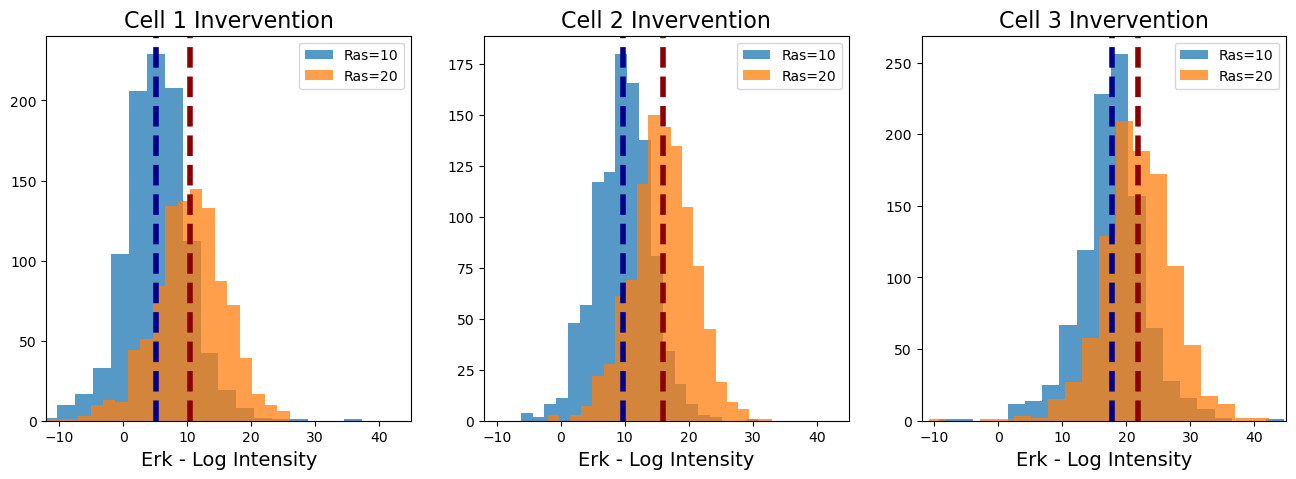

In [44]:
fig, ax = plt.subplots(1,3,figsize=(16,5))

ax[0].hist(np.array(intervention_results["Cell1"][0]), label="Ras=10", alpha=.75, bins=20)
ax[0].axvline(np.mean(np.array(intervention_results["Cell1"][0])), color="darkblue", linestyle="dashed", lw=4)
ax[0].hist(np.array(intervention_results["Cell1"][1]), label="Ras=20", alpha=.75, bins=20)
ax[0].axvline(np.mean(np.array(intervention_results["Cell1"][1])), color="darkred", linestyle="dashed", lw=4)
ax[0].legend()

ax[1].hist(np.array(intervention_results["Cell2"][0]), label="Ras=10", alpha=.75, bins=20)
ax[1].axvline(np.mean(np.array(intervention_results["Cell2"][0])), color="darkblue", linestyle="dashed", lw=4)
ax[1].hist(np.array(intervention_results["Cell2"][1]), label="Ras=20", alpha=.75, bins=20)
ax[1].axvline(np.mean(np.array(intervention_results["Cell2"][1])), color="darkred", linestyle="dashed", lw=4)
ax[1].legend()

ax[2].hist(np.array(intervention_results["Cell3"][0]), label="Ras=10", alpha=.75, bins=20)
ax[2].axvline(np.mean(np.array(intervention_results["Cell3"][0])), color="darkblue", linestyle="dashed", lw=4)
ax[2].hist(np.array(intervention_results["Cell3"][1]), label="Ras=20", alpha=.75, bins=20)
ax[2].axvline(np.mean(np.array(intervention_results["Cell3"][1])), color="darkred", linestyle="dashed", lw=4)
ax[2].legend()

ax[0].set_title("Cell 1 Invervention", fontsize=16)
ax[1].set_title("Cell 2 Invervention", fontsize=16)
ax[2].set_title("Cell 3 Invervention", fontsize=16)
ax[0].set_xlim(-12, 45)
ax[1].set_xlim(-12, 45)
ax[2].set_xlim(-12, 45)
ax[0].set_xlabel("Erk - Log Intensity", size=14)
ax[1].set_xlabel("Erk - Log Intensity", size=14)
ax[2].set_xlabel("Erk - Log Intensity", size=14)
# ax.set_ylabel("Erk", size=24)

In [45]:
np.mean(np.array(intervention_results["Cell1"][1])) - np.mean(np.array(intervention_results["Cell1"][0]))

5.2443957

In [46]:
np.mean(np.array(intervention_results["Cell2"][1])) - np.mean(np.array(intervention_results["Cell2"][0]))

6.186

In [47]:
np.mean(np.array(intervention_results["Cell3"][1])) - np.mean(np.array(intervention_results["Cell3"][0]))

4.044365

## Low vs High Replicates

Compare causal effect estimation using different numbers of replicates.

### Simulate Data

In [45]:
low_rep_data = simulate_data(bulk_graph, coefficients=cell_coef, include_missing=True, n=10, seed=1)
med_rep_data = simulate_data(bulk_graph, coefficients=cell_coef, include_missing=True, n=50, seed=0)
high_rep_data = simulate_data(bulk_graph, coefficients=cell_coef, include_missing=True, n=250, seed=0)
very_high_rep_data = simulate_data(bulk_graph, coefficients=cell_coef, include_missing=True, n=1000, seed=0)

simulating data...
adding feature level data...


/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:200: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_level_data = pd.concat([feature_level_data, pd.DataFrame({"Protein": [node],
/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:200: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_level_data = pd.con

masking data...


In [48]:
low_rep_data["Feature_data"].to_csv("../data/IGF_pathway/low_rep_feature_data.csv", index=False)
med_rep_data["Feature_data"].to_csv("../data/IGF_pathway/med_rep_feature_data.csv", index=False)
high_rep_data["Feature_data"].to_csv("../data/IGF_pathway/high_rep_feature_data.csv", index=False)
very_high_rep_data["Feature_data"].to_csv("../data/IGF_pathway/very_high_rep_feature_data.csv", index=False)

In [11]:
low_rep_protein_data = pd.read_csv("../data/IGF_pathway/low_rep_protein_data.csv")
med_rep_protein_data = pd.read_csv("../data/IGF_pathway/med_rep_protein_data.csv")
high_rep_protein_data = pd.read_csv("../data/IGF_pathway/high_rep_protein_data.csv")
very_high_protein_data = pd.read_csv("../data/IGF_pathway/very_high_rep_protein_data.csv")

### Initial Analysis

Text(0, 0.5, 'Erk')

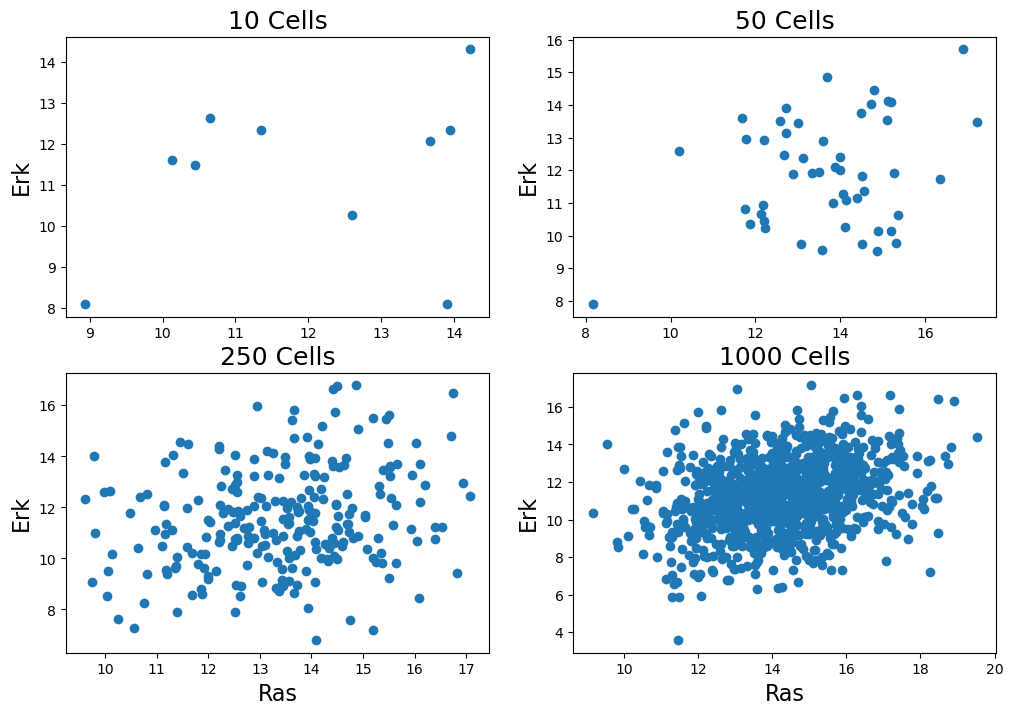

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))

ax[0,0].scatter(low_rep_protein_data["Ras"], low_rep_protein_data["Erk"])
ax[0,1].scatter(med_rep_protein_data["Ras"], med_rep_protein_data["Erk"])
ax[1,0].scatter(high_rep_protein_data["Ras"], high_rep_protein_data["Erk"])
ax[1,1].scatter(very_high_protein_data["Ras"], very_high_protein_data["Erk"])

ax[0,0].set_title("10 Cells", fontsize=18)
ax[0,1].set_title("50 Cells", fontsize=18)
ax[1,0].set_title("250 Cells", fontsize=18)
ax[1,1].set_title("1000 Cells", fontsize=18)

# ax[0,0].set_xlabel("Raf", fontsize=16)
# ax[0,1].set_xlabel("Raf", fontsize=16)
ax[1,0].set_xlabel("Ras", fontsize=16)
ax[1,1].set_xlabel("Ras", fontsize=16)

ax[0,0].set_ylabel("Erk", fontsize=16)
ax[0,1].set_ylabel("Erk", fontsize=16)
ax[1,0].set_ylabel("Erk", fontsize=16)
ax[1,1].set_ylabel("Erk", fontsize=16)

### Run inference

In [ ]:
datasets = {"low" : low_rep_protein_data, "med" : med_rep_protein_data, 
            "high" : high_rep_protein_data, "very_high" : very_high_protein_data}

intervention_results = dict()

for name, data in datasets.items():
    scm = SCM(data, y0_graph_bulk)
    scm.prepare_scm_input()
    scm.fit_scm(num_samples=1000, warmup_steps=6000, num_chains=4)
    
    scm.intervention("Ras", "Erk", 10)
    first_int = scm.intervention_samples
    
    scm.intervention("Ras", "Erk", 20)
    second_int = scm.intervention_samples
    
    intervention_results[name] = [first_int, second_int, scm]

Finding root nodes...
Adding latent confounders to graph...
Determining missing obs...
Running MCMC...


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

Finding root nodes...
Adding latent confounders to graph...
Determining missing obs...
Running MCMC...


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

Finding root nodes...
Adding latent confounders to graph...
Determining missing obs...
Running MCMC...


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

Finding root nodes...
Adding latent confounders to graph...
Determining missing obs...
Running MCMC...


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

### Compare to ground truth

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))

ax[0,0].hist(intervention_results["low"][0], label="Ras=10", alpha=.75, bins=30)
ax[0,0].hist(intervention_results["low"][1], label="Ras=20", alpha=.75, bins=30)
ax[0,0].axvline(x=np.mean(intervention_results["low"][0]), color="darkblue", lw=3, linestyle="--")
ax[0,0].axvline(x=np.mean(intervention_results["low"][1]), color="darkred", lw=3, linestyle="--")
ax[0,0].legend()

ax[0,1].hist(intervention_results["med"][0], label="Ras=10", alpha=.75, bins=30)
ax[0,1].hist(intervention_results["med"][1], label="Ras=20", alpha=.75, bins=30)
ax[0,1].axvline(x=np.mean(intervention_results["med"][0]), color="darkblue", lw=3, linestyle="--")
ax[0,1].axvline(x=np.mean(intervention_results["med"][1]), color="darkred", lw=3, linestyle="--")
ax[0,1].legend()

ax[1,0].hist(intervention_results["high"][0], label="Ras=10", alpha=.75, bins=30)
ax[1,0].hist(intervention_results["high"][1], label="Ras=20", alpha=.75, bins=30)
ax[1,0].axvline(x=np.mean(intervention_results["high"][0]), color="darkblue", lw=3, linestyle="--")
ax[1,0].axvline(x=np.mean(intervention_results["high"][1]), color="darkred", lw=3, linestyle="--")
ax[1,0].legend()

ax[1,1].hist(intervention_results["very_high"][0], label="Ras=10", alpha=.75, bins=30)
ax[1,1].hist(intervention_results["very_high"][1], label="Ras=20", alpha=.75, bins=30)
ax[1,1].axvline(x=np.mean(intervention_results["very_high"][0]), color="darkblue", lw=3, linestyle="--")
ax[1,1].axvline(x=np.mean(intervention_results["very_high"][1]), color="darkred", lw=3, linestyle="--")
ax[1,1].legend(fontsize=20)

ax[0,0].set_xlim(-40,80)
ax[0,1].set_xlim(-40,80)
ax[1,0].set_xlim(-40,80)
ax[1,1].set_xlim(-40,80)

plt.legend()
ax[0,0].set_title("10 Cells", fontsize=18)
ax[0,1].set_title("50 Cells", fontsize=18)
ax[1,0].set_title("250 Cells", fontsize=18)
ax[1,1].set_title("1000 Cells", fontsize=18)

ax[1,0].set_xlabel("Erk - Log Intensity", size=16)
ax[1,1].set_xlabel("Erk - Log Intensity", size=16)

## Low vs High Replicates - Bulk

### Simulate data

In [16]:
low_rep_bulk_data = simulate_data(cell_type_graph, coefficients=cell_coef, include_missing=True, 
                                  cell_type=True, n_cells=3, n=30, seed=0)
med_rep_bulk_data = simulate_data(cell_type_graph, coefficients=cell_coef, include_missing=True, 
                                  cell_type=True, n_cells=3, n=100, seed=0)
high_rep_bulk_data = simulate_data(cell_type_graph, coefficients=cell_coef, include_missing=True, 
                                   cell_type=True, n_cells=3, n=250, seed=0)
very_high_rep_bulk_data = simulate_data(cell_type_graph, coefficients=cell_coef, include_missing=True, 
                                        cell_type=True, n_cells=3, n=1000, seed=1)

simulating data...
adding feature level data...


/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:200: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_level_data = pd.concat([feature_level_data, pd.DataFrame({"Protein": [node],
/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:200: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_level_data = pd.con

masking data...


/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:239: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_level_data.loc[i, "MAR"] = False
/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:245: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_level_data.loc[i, "MNAR"] = False


simulating data...
adding feature level data...


/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:200: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_level_data = pd.concat([feature_level_data, pd.DataFrame({"Protein": [node],
/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:200: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_level_data = pd.con

masking data...


/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:239: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_level_data.loc[i, "MAR"] = False
/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:245: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_level_data.loc[i, "MNAR"] = False


simulating data...
adding feature level data...


/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:200: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_level_data = pd.concat([feature_level_data, pd.DataFrame({"Protein": [node],
/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:200: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_level_data = pd.con

masking data...


/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:237: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_level_data.loc[i, "MAR"] = True
/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:245: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_level_data.loc[i, "MNAR"] = False


simulating data...
adding feature level data...


/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:200: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_level_data = pd.concat([feature_level_data, pd.DataFrame({"Protein": [node],
/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:200: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_level_data = pd.con

masking data...


/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:239: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_level_data.loc[i, "MAR"] = False
/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:245: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_level_data.loc[i, "MNAR"] = False


In [17]:
low_rep_bulk_data["Feature_data"].to_csv("../data/IGF_pathway/low_rep_bulk_feature_data.csv", index=False)
med_rep_bulk_data["Feature_data"].to_csv("../data/IGF_pathway/med_rep_bulk_feature_data.csv", index=False)
high_rep_bulk_data["Feature_data"].to_csv("../data/IGF_pathway/high_rep_bulk_feature_data.csv", index=False)
very_high_rep_bulk_data["Feature_data"].to_csv("../data/IGF_pathway/very_high_rep_bulk_feature_data.csv", index=False)

In [18]:
low_rep_bulk_protein_data = pd.read_csv("../data/IGF_pathway/low_rep_bulk_protein_data.csv")
med_rep_bulk_protein_data = pd.read_csv("../data/IGF_pathway/med_rep_bulk_protein_data.csv")
high_rep_bulk_protein_data = pd.read_csv("../data/IGF_pathway/high_rep_bulk_protein_data.csv")
very_high_bulk_protein_data = pd.read_csv("../data/IGF_pathway/very_high_rep_bulk_protein_data.csv")

### Analysis

Text(0, 0.5, 'Erk')

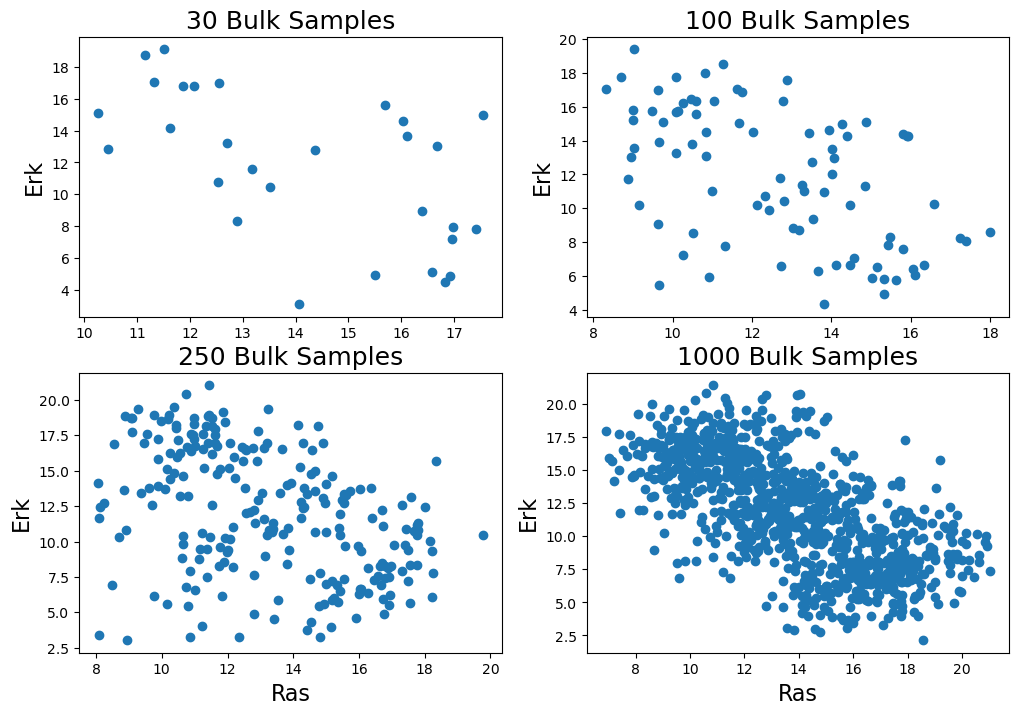

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))

ax[0,0].scatter(low_rep_bulk_protein_data["Ras"], low_rep_bulk_protein_data["Erk"])
ax[0,1].scatter(med_rep_bulk_protein_data["Ras"], med_rep_bulk_protein_data["Erk"])
ax[1,0].scatter(high_rep_bulk_protein_data["Ras"], high_rep_bulk_protein_data["Erk"])
ax[1,1].scatter(very_high_bulk_protein_data["Ras"], very_high_bulk_protein_data["Erk"])

ax[0,0].set_title("30 Bulk Samples", fontsize=18)
ax[0,1].set_title("100 Bulk Samples", fontsize=18)
ax[1,0].set_title("250 Bulk Samples", fontsize=18)
ax[1,1].set_title("1000 Bulk Samples", fontsize=18)

# ax[0,0].set_xlabel("Raf", fontsize=16)
# ax[0,1].set_xlabel("Raf", fontsize=16)
ax[1,0].set_xlabel("Ras", fontsize=16)
ax[1,1].set_xlabel("Ras", fontsize=16)

ax[0,0].set_ylabel("Erk", fontsize=16)
ax[0,1].set_ylabel("Erk", fontsize=16)
ax[1,0].set_ylabel("Erk", fontsize=16)
ax[1,1].set_ylabel("Erk", fontsize=16)

### Run inference

In [21]:
datasets = {"low" : low_rep_bulk_protein_data, "med" : med_rep_bulk_protein_data, 
            "high" : high_rep_bulk_protein_data, "very_high" : very_high_bulk_protein_data}

intervention_results = dict()

for name, data in datasets.items():
    scm = SCM(data, y0_graph_bulk)
    scm.prepare_scm_input()
    scm.fit_scm(num_samples=1000, warmup_steps=5000, num_chains=4)
    
    scm.intervention("Ras", "Erk", 10)
    first_int = scm.intervention_samples
    
    scm.intervention("Ras", "Erk", 20)
    second_int = scm.intervention_samples
    
    intervention_results[name] = [first_int, second_int, scm]

Finding root nodes...
Adding latent confounders to graph...
Determining missing obs...
Running MCMC...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Finding root nodes...
Adding latent confounders to graph...
Determining missing obs...
Running MCMC...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Finding root nodes...
Adding latent confounders to graph...
Determining missing obs...
Running MCMC...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Finding root nodes...
Adding latent confounders to graph...
Determining missing obs...
Running MCMC...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Text(0.5, 0, 'Erk - Log Intensity')

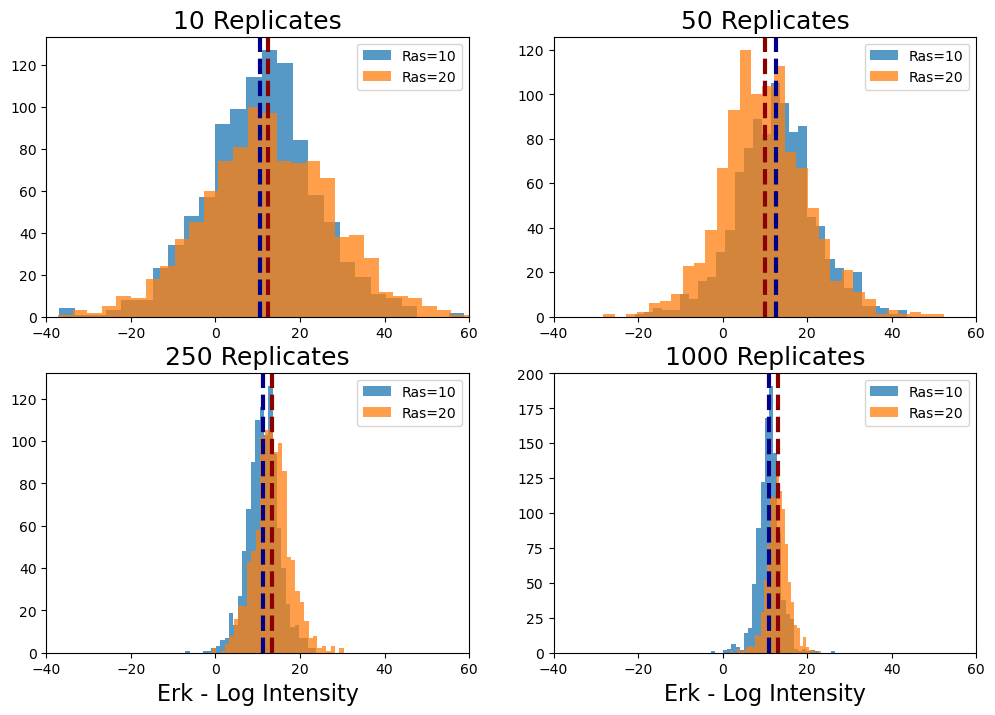

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))

ax[0,0].hist(intervention_results["low"][0], label="Ras=10", alpha=.75, bins=30)
ax[0,0].hist(intervention_results["low"][1], label="Ras=20", alpha=.75, bins=30)
ax[0,0].axvline(x=np.mean(intervention_results["low"][0]), color="darkblue", lw=3, linestyle="--")
ax[0,0].axvline(x=np.mean(intervention_results["low"][1]), color="darkred", lw=3, linestyle="--")
ax[0,0].legend()

ax[0,1].hist(intervention_results["med"][0], label="Ras=10", alpha=.75, bins=30)
ax[0,1].hist(intervention_results["med"][1], label="Ras=20", alpha=.75, bins=30)
ax[0,1].axvline(x=np.mean(intervention_results["med"][0]), color="darkblue", lw=3, linestyle="--")
ax[0,1].axvline(x=np.mean(intervention_results["med"][1]), color="darkred", lw=3, linestyle="--")
ax[0,1].legend()

ax[1,0].hist(intervention_results["high"][0], label="Ras=10", alpha=.75, bins=30)
ax[1,0].hist(intervention_results["high"][1], label="Ras=20", alpha=.75, bins=30)
ax[1,0].axvline(x=np.mean(intervention_results["high"][0]), color="darkblue", lw=3, linestyle="--")
ax[1,0].axvline(x=np.mean(intervention_results["high"][1]), color="darkred", lw=3, linestyle="--")
ax[1,0].legend()

ax[1,1].hist(intervention_results["very_high"][0], label="Ras=10", alpha=.75, bins=30)
ax[1,1].hist(intervention_results["very_high"][1], label="Ras=20", alpha=.75, bins=30)
ax[1,1].axvline(x=np.mean(intervention_results["very_high"][0]), color="darkblue", lw=3, linestyle="--")
ax[1,1].axvline(x=np.mean(intervention_results["very_high"][1]), color="darkred", lw=3, linestyle="--")
ax[1,1].legend()

ax[0,0].set_xlim(-40,60)
ax[0,1].set_xlim(-40,60)
ax[1,0].set_xlim(-40,60)
ax[1,1].set_xlim(-40,60)

ax[0,0].set_title("10 Replicates", fontsize=18)
ax[0,1].set_title("50 Replicates", fontsize=18)
ax[1,0].set_title("250 Replicates", fontsize=18)
ax[1,1].set_title("1000 Replicates", fontsize=18)

ax[1,0].set_xlabel("Erk - Log Intensity", size=16)
ax[1,1].set_xlabel("Erk - Log Intensity", size=16)

## High dynamic range

In [42]:
## Coefficients for relations
cell_coef_high_range = {'EGF': {'intercept': 18., "error": 8},
              'IGF': {'intercept': 17., "error": 8},
              'SOS': {'intercept': -4, "error": 1, 
                      'EGF': 0.6, 'IGF': 0.6,},
              'Ras': {'intercept': 5, "error": 1, 'SOS': .5, "cell_type" : [3, 0, -3]},
              'PI3K': {'intercept': 1.6, "error": 1, 
                       'EGF': .5, 'IGF': 0.5, 'Ras': .5,},
              'Akt': {'intercept': 2., "error": 1, 'PI3K': 0.75, },
              'Raf': {'intercept': 2, "error": 1,
                      'Ras': 0.8, 'Akt': -.4, "cell_type" : [-2, 0, 2]},
              'Mek': {'intercept': 3., "error": 1, 'Raf': 0.75, "cell_type" : [-2, 0, 2]},
              'Erk': {'intercept': 4., "error": 1, 'Mek': 1.2, "cell_type" : [-2, 0, 2]}
             }

In [43]:
low_rep_range_data = simulate_data(cell_type_graph, coefficients=cell_coef_high_range, include_missing=True, 
                                  cell_type=True, n_cells=3, n=30, seed=0)
med_rep_range_data = simulate_data(cell_type_graph, coefficients=cell_coef_high_range, include_missing=True, 
                                  cell_type=True, n_cells=3, n=100, seed=0)
high_rep_range_data = simulate_data(cell_type_graph, coefficients=cell_coef_high_range, include_missing=True, 
                                   cell_type=True, n_cells=3, n=250, seed=0)
# very_high_rep_bulk_data = simulate_data(cell_type_graph, coefficients=cell_coef, include_missing=True, 
#                                         cell_type=True, n_cells=3, n=1000, seed=1)

simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level data...
masking data...


In [48]:
low_rep_range_data["Feature_data"].to_csv("../data/IGF_pathway/low_rep_range_feature_data.csv", index=False)
med_rep_range_data["Feature_data"].to_csv("../data/IGF_pathway/med_rep_range_feature_data.csv", index=False)
high_rep_range_data["Feature_data"].to_csv("../data/IGF_pathway/high_rep_range_feature_data.csv", index=False)

In [53]:
low_rep_range_protein_data = pd.read_csv("../data/IGF_pathway/low_rep_range_protein_data.csv")
med_rep_range_protein_data = pd.read_csv("../data/IGF_pathway/med_rep_range_protein_data.csv")
high_rep_range_protein_data = pd.read_csv("../data/IGF_pathway/high_rep_range_protein_data.csv")

### Analysis

Text(0, 0.5, 'Mek')

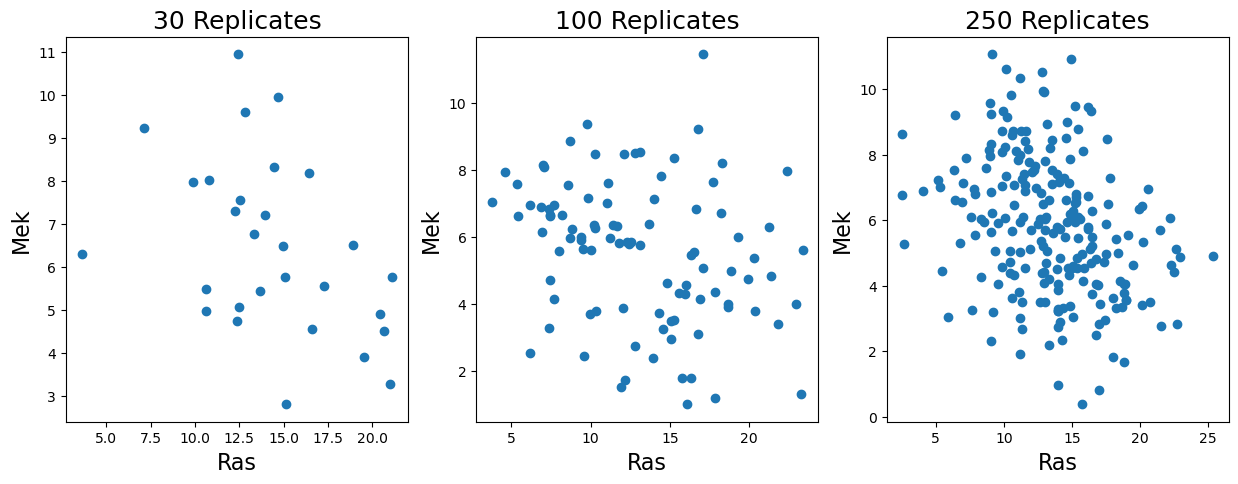

In [60]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

ax[0].scatter(low_rep_range_protein_data["Ras"], low_rep_range_protein_data["Mek"])
ax[1].scatter(med_rep_range_protein_data["Ras"], med_rep_range_protein_data["Mek"])
ax[2].scatter(high_rep_range_protein_data["Ras"], high_rep_range_protein_data["Mek"])

ax[0].set_title("30 Replicates", fontsize=18)
ax[1].set_title("100 Replicates", fontsize=18)
ax[2].set_title("250 Replicates", fontsize=18)

# ax[0,0].s|et_xlabel("Raf", fontsize=16)
# ax[0,1].set_xlabel("Raf", fontsize=16)
ax[0].set_xlabel("Ras", fontsize=16)
ax[1].set_xlabel("Ras", fontsize=16)
ax[2].set_xlabel("Ras", fontsize=16)

                  
ax[0].set_ylabel("Mek", fontsize=16)
ax[1].set_ylabel("Mek", fontsize=16)
ax[2].set_ylabel("Mek", fontsize=16)

### Run inference

In [61]:
datasets = {"low" : low_rep_range_protein_data, "med" : med_rep_range_protein_data, 
            "high" : high_rep_range_protein_data}

intervention_results = dict()

for name, data in datasets.items():
    scm = SCM(data, y0_graph_bulk)
    scm.prepare_scm_input()
    scm.fit_scm(num_samples=1000, warmup_steps=3000, num_chains=4)
    
    scm.intervention("Ras", "Erk", 10)
    first_int = scm.intervention_samples
    
    scm.intervention("Ras", "Erk", 20)
    second_int = scm.intervention_samples
    
    intervention_results[name] = [first_int, second_int, scm]

Finding root nodes...
Adding latent confounders to graph...
Determining missing obs...
Running MCMC...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Finding root nodes...
Adding latent confounders to graph...
Determining missing obs...
Running MCMC...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Finding root nodes...
Adding latent confounders to graph...
Determining missing obs...
Running MCMC...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Log Intensity')

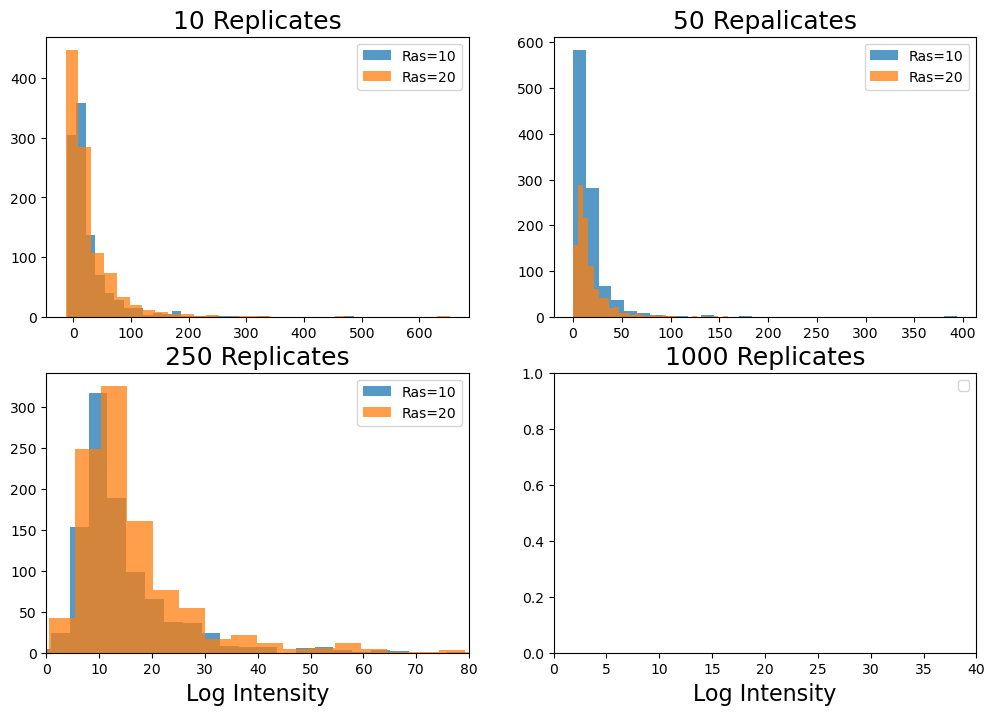

In [62]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))

ax[0,0].hist(intervention_results["low"][0], label="Ras=10", alpha=.75, bins=30)
ax[0,0].hist(intervention_results["low"][1], label="Ras=20", alpha=.75, bins=30)
# ax[0,0].axvline(x=np.mean(gt_int_data[0]), color="Blue", lw=2, linestyle="--", label="Ground Truth Ras=10")
# ax[0,0].axvline(x=np.mean(gt_int_data[1]), color="Red", lw=2, linestyle="--", label="Ground Truth Ras=20")
ax[0,0].legend()

ax[0,1].hist(intervention_results["med"][0], label="Ras=10", alpha=.75, bins=30)
ax[0,1].hist(intervention_results["med"][1], label="Ras=20", alpha=.75, bins=30)
# ax[0,1].axvline(x=np.mean(gt_int_data[0]), color="Blue", lw=2, linestyle="--", label="Ground Truth Ras=10")
# ax[0,1].axvline(x=np.mean(gt_int_data[1]), color="Red", lw=2, linestyle="--", label="Ground Truth Ras=20")
ax[0,1].legend()

ax[1,0].hist(intervention_results["high"][0], label="Ras=10", alpha=.75, bins=30)
ax[1,0].hist(intervention_results["high"][1], label="Ras=20", alpha=.75, bins=30)
# ax[1,0].axvline(x=np.mean(gt_int_data[0]), color="Blue", lw=2, linestyle="--", label="Ground Truth Ras=10")
# ax[1,0].axvline(x=np.mean(gt_int_data[1]), color="Red", lw=2, linestyle="--", label="Ground Truth Ras=20")
ax[1,0].legend()

# ax[1,1].hist(intervention_results["very_high"][0], label="Ras=10", alpha=.75, bins=30)
# ax[1,1].hist(intervention_results["very_high"][1], label="Ras=20", alpha=.75, bins=30)
# ax[1,1].axvline(x=np.mean(gt_int_data[0]), color="Blue", lw=2, linestyle="--", label="Ground Truth Ras=10")
# ax[1,1].axvline(x=np.mean(gt_int_data[1]), color="Red", lw=2, linestyle="--", label="Ground Truth Ras=20")
# ax[1,1].legend(fontsize=20)

ax[1,0].set_xlim(0,80)
ax[1,1].set_xlim(0,40)

plt.legend()
ax[0,0].set_title("10 Replicates", fontsize=18)
ax[0,1].set_title("50 Repalicates", fontsize=18)
ax[1,0].set_title("250 Replicates", fontsize=18)
ax[1,1].set_title("1000 Replicates", fontsize=18)

ax[1,0].set_xlabel("Log Intensity", fontsize=16)
ax[1,1].set_xlabel("Log Intensity", fontsize=16)

## Bad node measurements

Here we simulate a high error for Mek, which is along the causal path from Ras to Erk

In [65]:
bad_node_data = simulate_data(cell_type_graph, coefficients=cell_coef, include_missing=True, 
                              add_error=True, error_node="Mek", n=250, seed=1)

simulating data...
adding feature level data...


/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:201: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_level_data = pd.concat([feature_level_data, pd.DataFrame({"Protein": [node],
/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:201: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_level_data = pd.con

masking data...


/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:240: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_level_data.loc[i, "MAR"] = False
/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:246: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_level_data.loc[i, "MNAR"] = False


In [66]:
bad_node_data["Feature_data"].to_csv("../data/IGF_pathway/bad_node_feature_data.csv", index=False)

In [70]:
bad_node_protein_data = pd.read_csv("../data/IGF_pathway/bad_node_protein_data.csv")

### Analysis

In [71]:
single_cell_lm = linear_model.LinearRegression()

ras_erk_lm = linear_model.LinearRegression()
x = bad_node_protein_data.dropna()[["Ras"]]
y = bad_node_protein_data.dropna()[["Erk"]]
ras_erk_lm.fit(x, y)

LinearRegression()

(array([ 4.,  6.,  8., 10., 12., 14., 16., 18.]),
 [Text(0, 4.0, '4'),
  Text(0, 6.0, '6'),
  Text(0, 8.0, '8'),
  Text(0, 10.0, '10'),
  Text(0, 12.0, '12'),
  Text(0, 14.0, '14'),
  Text(0, 16.0, '16'),
  Text(0, 18.0, '18')])

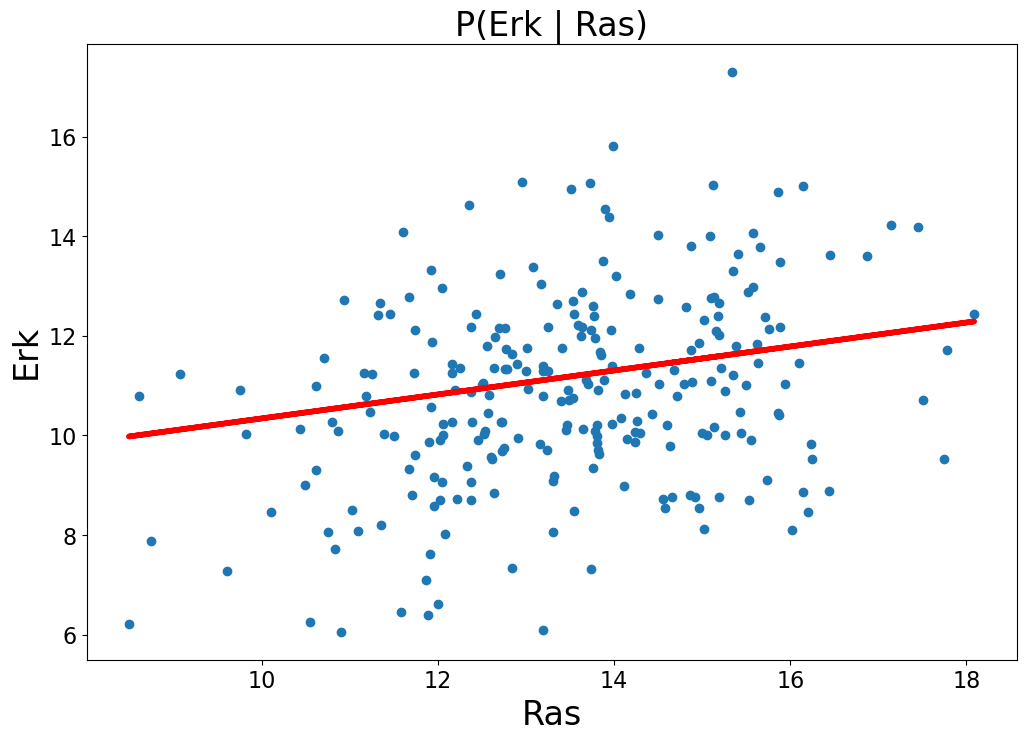

In [72]:
fig, ax = plt.subplots(figsize=(12,8))

x = bad_node_protein_data["Ras"]
y = bad_node_protein_data["Erk"]

ax.scatter(x, y)
ax.plot(bad_node_protein_data["Ras"], 
           ras_erk_lm.coef_[0]*bad_node_protein_data["Ras"] + ras_erk_lm.intercept_[0], 
           color="red", lw=4)

ax.set_title("P(Erk | Ras)", size=24)
ax.set_xlabel("Ras", size=24)
ax.set_ylabel("Erk", size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [73]:
single_cell_lm = linear_model.LinearRegression()

ras_raf_lm = linear_model.LinearRegression()
x = bad_node_protein_data.dropna()[["Ras"]]
y = bad_node_protein_data.dropna()[["Raf"]]
ras_raf_lm.fit(x, y)

raf_mek_lm = linear_model.LinearRegression()
x = bad_node_protein_data.dropna()[["Raf"]]
y = bad_node_protein_data.dropna()[["Mek"]]
raf_mek_lm.fit(x, y)

mek_erk_lm = linear_model.LinearRegression()
x = bad_node_protein_data.dropna()[["Mek"]]
y = bad_node_protein_data.dropna()[["Erk"]]
mek_erk_lm.fit(x, y)

LinearRegression()

Text(0, 0.5, 'Erk')

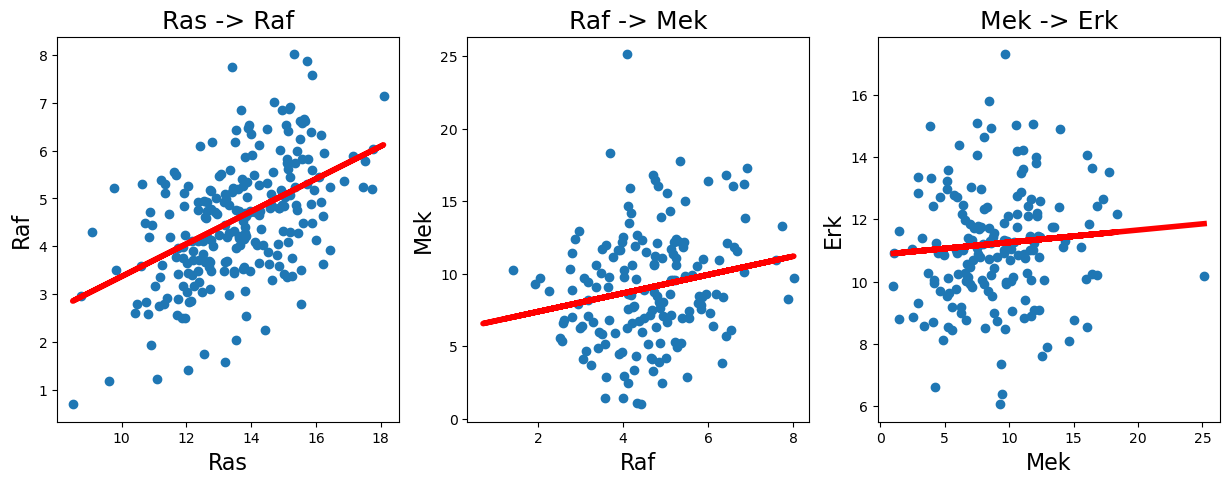

In [74]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].scatter(bad_node_protein_data["Ras"], bad_node_protein_data["Raf"])
ax[0].plot(bad_node_protein_data["Ras"], 
           ras_raf_lm.coef_[0]*bad_node_protein_data["Ras"] + ras_raf_lm.intercept_[0], 
           color="red", lw=4)

ax[1].scatter(bad_node_protein_data["Raf"], bad_node_protein_data["Mek"])
ax[1].plot(bad_node_protein_data["Raf"], 
           raf_mek_lm.coef_[0]*bad_node_protein_data["Raf"] + raf_mek_lm.intercept_[0], 
           color="red", lw=4)

ax[2].scatter(bad_node_protein_data["Mek"], bad_node_protein_data["Erk"])
ax[2].plot(bad_node_protein_data["Mek"], 
           mek_erk_lm.coef_[0]*bad_node_protein_data["Mek"] + mek_erk_lm.intercept_[0], 
           color="red", lw=4)

ax[0].set_title("Ras -> Raf", fontsize=18)
ax[1].set_title("Raf -> Mek", fontsize=18)
ax[2].set_title("Mek -> Erk", fontsize=18)

ax[0].set_xlabel("Ras", fontsize=16)                  
ax[0].set_ylabel("Raf", fontsize=16)

ax[1].set_xlabel("Raf", fontsize=16)                  
ax[1].set_ylabel("Mek", fontsize=16)

ax[2].set_xlabel("Mek", fontsize=16)                  
ax[2].set_ylabel("Erk", fontsize=16)

### Run inference

In [75]:
scm = SCM(bad_node_protein_data, y0_graph_bulk)
scm.prepare_scm_input()
scm.fit_scm(num_samples=1000, warmup_steps=4000, num_chains=4)

scm.intervention("Ras", "Erk", 10)
first_int = scm.intervention_samples

scm.intervention("Ras", "Erk", 20)
second_int = scm.intervention_samples

Finding root nodes...
Adding latent confounders to graph...
Determining missing obs...
Running MCMC...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [76]:
np.mean(np.array(second_int)) - np.mean(np.array(first_int))

0.32441425

(0.0, 25.0)

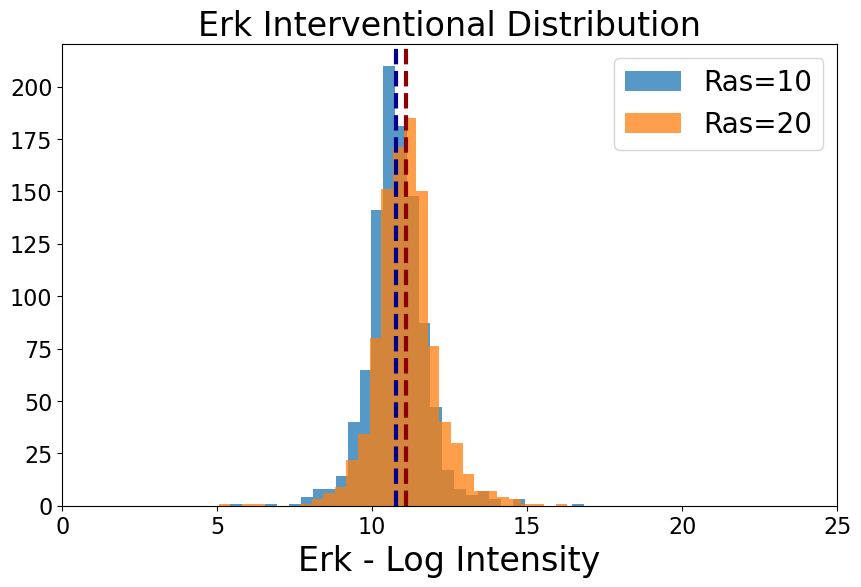

In [79]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(np.array(first_int), bins=30, alpha=.75, label="Ras=10")
ax.hist(np.array(second_int), bins=30, alpha=.75, label="Ras=20")
ax.axvline(x=np.mean(first_int), color="darkblue", lw=3, linestyle="--")
ax.axvline(x=np.mean(second_int), color="darkred", lw=3, linestyle="--")

ax.legend(fontsize=20)
ax.set_title("Erk Interventional Distribution", size=24)
ax.set_xlabel("Erk - Log Intensity", size=24)
# ax.set_ylabel("Erk", size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


ax.set_xlim(0,25)

### Remove Mek

In [80]:
y0_no_mek = copy.copy(y0_graph_bulk)
y0_no_mek.directed.remove_edge(Variable("Raf"), Variable("Mek"))
y0_no_mek.directed.remove_edge(Variable("Mek"), Variable("Erk"))
y0_no_mek.directed.add_edge(Variable("Raf"), Variable("Erk"))

In [81]:
scm = SCM(bad_node_protein_data, y0_no_mek)
scm.prepare_scm_input()
scm.fit_scm(num_samples=1000, warmup_steps=4000, num_chains=4)

scm.intervention("Ras", "Erk", 10)
first_int = scm.intervention_samples

scm.intervention("Ras", "Erk", 20)
second_int = scm.intervention_samples

Finding root nodes...
Adding latent confounders to graph...
Determining missing obs...
Running MCMC...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [82]:
np.mean(np.array(second_int)) - np.mean(np.array(first_int))

4.8653183

(0.0, 25.0)

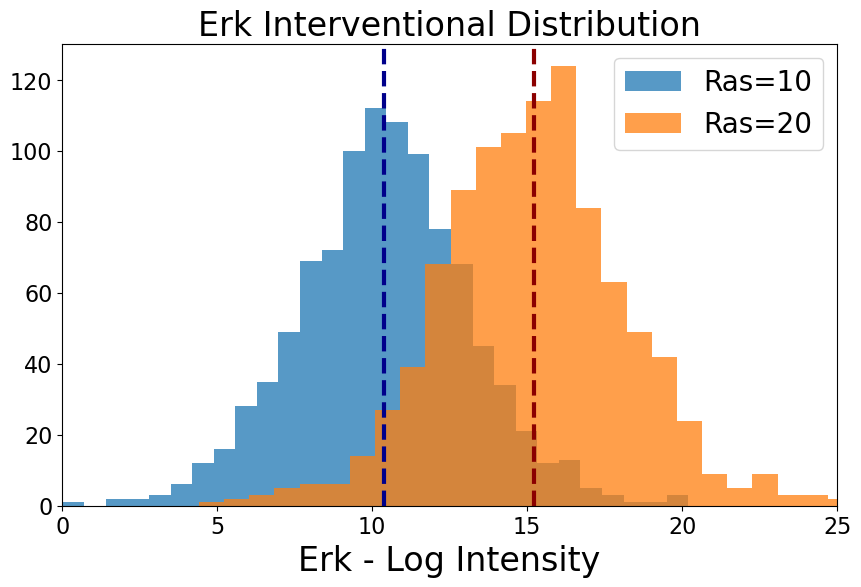

In [85]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(np.array(first_int), bins=30, alpha=.75, label="Ras=10")
ax.hist(np.array(second_int), bins=30, alpha=.75, label="Ras=20")
ax.axvline(x=np.mean(first_int), color="darkblue", lw=3, linestyle="--")
ax.axvline(x=np.mean(second_int), color="darkred", lw=3, linestyle="--")

ax.legend(fontsize=20)
ax.set_title("Erk Interventional Distribution", size=24)
ax.set_xlabel("Erk - Log Intensity", size=24)
# ax.set_ylabel("Erk", size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


ax.set_xlim(0,25)

## Missingness

### Simulate Data

In [8]:
high_missing_data = simulate_data(bulk_graph, coefficients=cell_coef, include_missing=True, 
                                  mar_missing_param=.1, mnar_missing_param=[-3, .15], 
                                  n=250, seed=0)

simulating data...
adding feature level data...


/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:200: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_level_data = pd.concat([feature_level_data, pd.DataFrame({"Protein": [node],
/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:200: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_level_data = pd.con

masking data...


/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:237: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_level_data.loc[i, "MAR"] = True
/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:245: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_level_data.loc[i, "MNAR"] = False


In [13]:
high_missing_data["Feature_data"].to_csv("../data/IGF_pathway/high_missing_feature_data.csv", index=False)

In [105]:
high_missing_protein_data = pd.read_csv("../data/IGF_pathway/high_missing_protein_data.csv")

### Initial Analysis

Text(0.5, 1.0, 'MNAR Curve - High Probability')

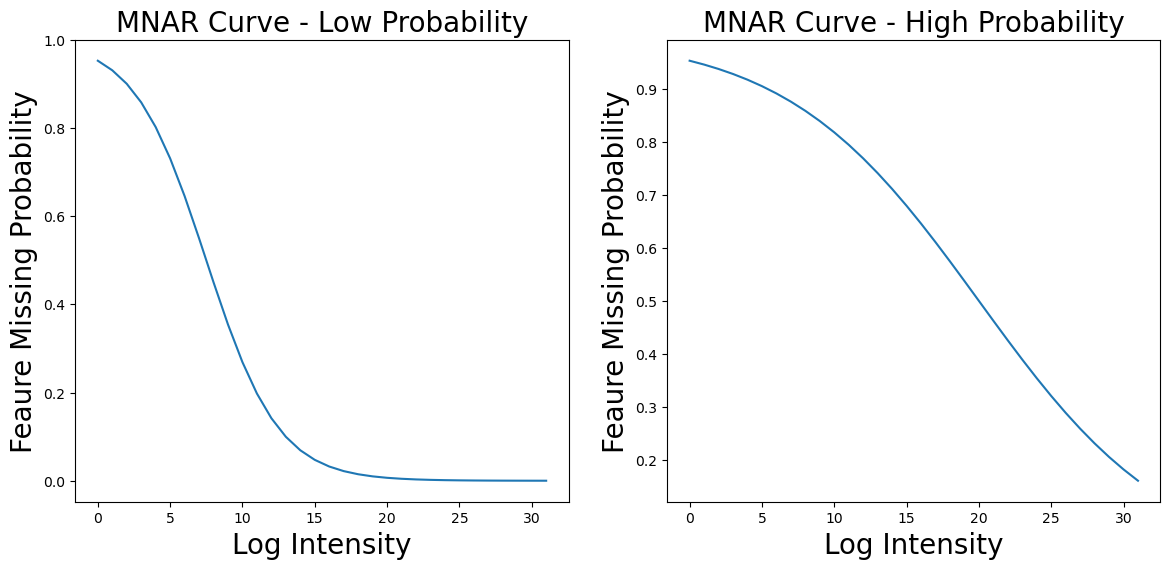

In [87]:
fig, ax = plt.subplots(1,2,figsize=(14,6))


mnar_thresh = [1 / (1 + np.exp(-3 + (.4 * i))) for i in range(0, 32)]
ax[0].plot(mnar_thresh)

mnar_thresh = [1 / (1 + np.exp(-3 + (.15 * i))) for i in range(0, 32)]
ax[1].plot(mnar_thresh)

ax[0].set_xlabel("Log Intensity", size=20)
ax[1].set_xlabel("Log Intensity", size=20)

ax[0].set_ylabel("Feaure Missing Probability", size=20)
ax[1].set_ylabel("Feaure Missing Probability", size=20)

ax[0].set_title("MNAR Curve - Low Probability", size=20)
ax[1].set_title("MNAR Curve - High Probability", size=20)

Text(0, 0.5, 'Percent Missing Replicates')

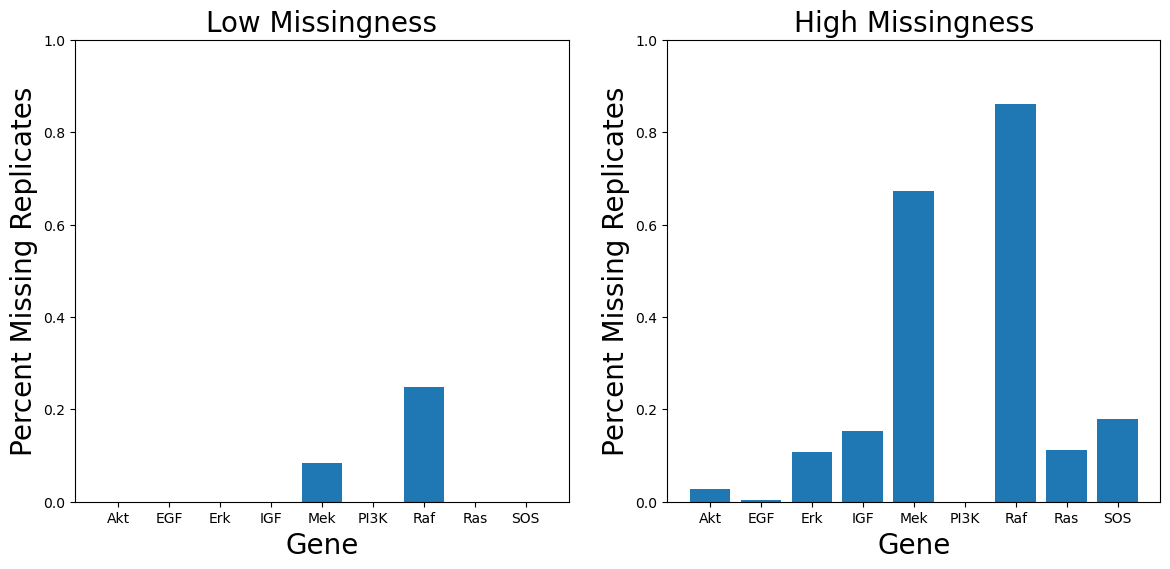

In [88]:
fig, ax = plt.subplots(1,2, figsize=(14,6))

ax[0].bar(x = high_rep_protein_data.iloc[: ,1:].isnull().sum(axis = 0).index,
          height=high_rep_protein_data.iloc[: ,1:].isnull().sum(axis = 0) / len(high_rep_protein_data))

ax[1].bar(x = high_missing_protein_data.iloc[: ,1:].isnull().sum(axis = 0).index, 
       height=high_missing_protein_data.iloc[: ,1:].isnull().sum(axis = 0) / len(high_missing_protein_data))

ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)

ax[0].set_title("Low Missingness", size=20)
ax[1].set_title("High Missingness", size=20)

ax[0].set_xlabel("Gene", size=20)
ax[1].set_xlabel("Gene", size=20)

ax[0].set_ylabel("Percent Missing Replicates", size=20)
ax[1].set_ylabel("Percent Missing Replicates", size=20)

In [89]:
low_missing_lm = linear_model.LinearRegression()
x = high_rep_protein_data.dropna()[["Raf"]]
y = high_rep_protein_data.dropna()[["Mek"]]
low_missing_lm.fit(x, y)

high_missing_lm = linear_model.LinearRegression()
x = high_missing_protein_data.dropna()[["Raf"]]
y = high_missing_protein_data.dropna()[["Mek"]]
high_missing_lm.fit(x, y)

LinearRegression()

Text(0, 0.5, 'Mek')

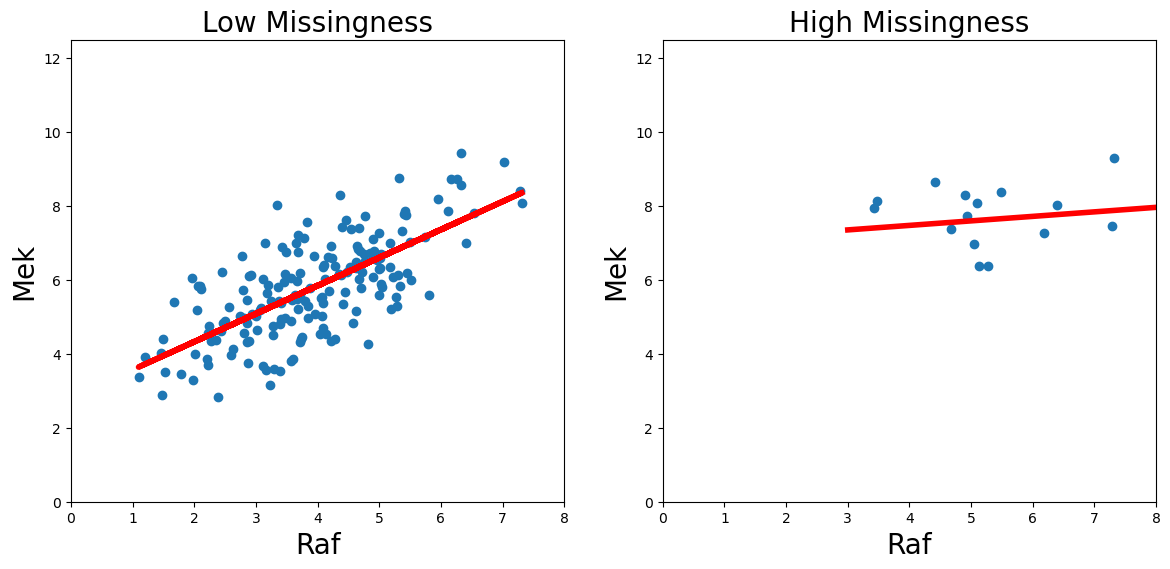

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].scatter(high_rep_protein_data["Raf"], high_rep_protein_data["Mek"])
ax[0].plot(high_rep_protein_data["Raf"], 
           low_missing_lm.coef_[0]*high_rep_protein_data["Raf"] + low_missing_lm.intercept_[0], 
           color="red", lw=4)

ax[1].scatter(high_missing_protein_data["Raf"], high_missing_protein_data["Mek"])
ax[1].plot(np.arange(3,8.5), 
           high_missing_lm.coef_[0]*np.arange(3,8.5) + high_missing_lm.intercept_[0], 
           color="red", lw=4)

ax[0].set_xlim(0,8)
ax[1].set_xlim(0,8)
ax[0].set_ylim(0,12.5)
ax[1].set_ylim(0,12.5)

ax[0].set_title("Low Missingness", size=20)
ax[1].set_title("High Missingness", size=20)

ax[0].set_xlabel("Raf", size=20)
ax[1].set_xlabel("Raf", size=20)

ax[0].set_ylabel("Mek", size=20)
ax[1].set_ylabel("Mek", size=20)

### Run inference

In [129]:
scm = SCM(high_missing_protein_data, y0_graph_bulk)
scm.prepare_scm_input()
scm.fit_scm(num_samples=1000, warmup_steps=10000, num_chains=4)

# scm.intervention("Ras", "Erk", 10)
# first_int = scm.intervention_samples

# scm.intervention("Ras", "Erk", 20)
# second_int = scm.intervention_samples

high_missing_intervention_results = [first_int, second_int]

Finding root nodes...
Adding latent confounders to graph...
Determining missing obs...
Running MCMC...


  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

In [135]:
np.mean(intervention_results["high"][1]) - np.mean(intervention_results["high"][0])

5.385112

In [136]:
np.mean(np.array(high_missing_intervention_results[1])) - np.mean(np.array(high_missing_intervention_results[0]))

5.28156

Text(0.5, 0, 'Erk - Log Intensity')

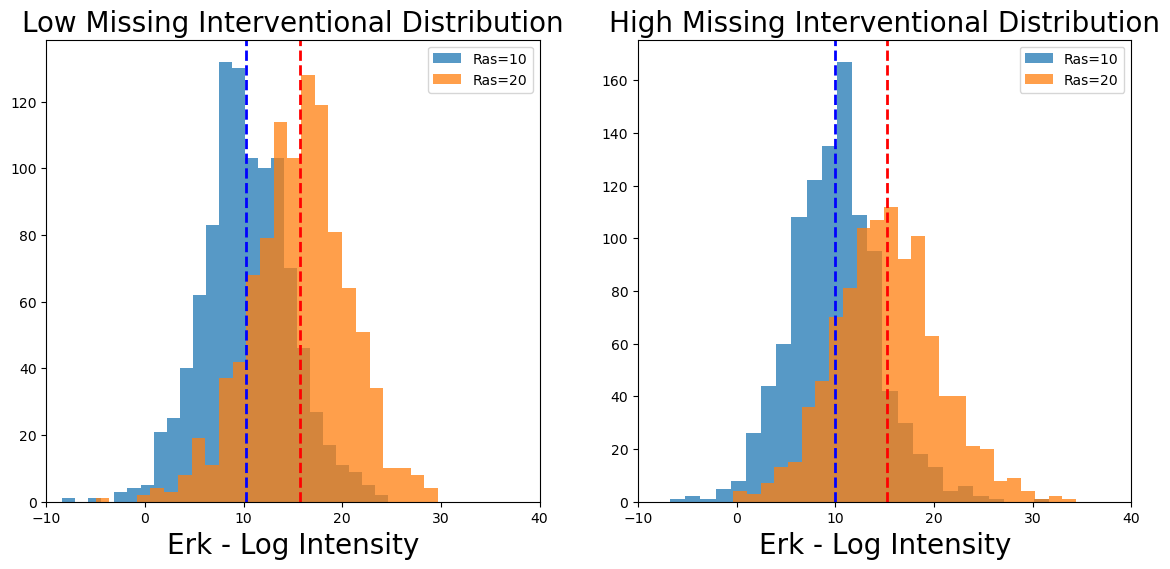

In [137]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].hist(intervention_results["high"][0], label="Ras=10", alpha=.75, bins=25)
ax[0].hist(intervention_results["high"][1], label="Ras=20", alpha=.75, bins=25)
ax[0].axvline(x=np.mean(intervention_results["high"][0]), color="Blue", lw=2, linestyle="--")
ax[0].axvline(x=np.mean(intervention_results["high"][1]), color="Red", lw=2, linestyle="--")
ax[0].legend()

ax[1].hist(high_missing_intervention_results[0], label="Ras=10", alpha=.75, bins=25)
ax[1].hist(high_missing_intervention_results[1], label="Ras=20", alpha=.75, bins=25)
ax[1].axvline(x=np.mean(high_missing_intervention_results[0]), color="Blue", lw=2, linestyle="--")
ax[1].axvline(x=np.mean(high_missing_intervention_results[1]), color="Red", lw=2, linestyle="--")
ax[1].legend()

ax[0].set_xlim(-10,40)
ax[1].set_xlim(-10,40)

plt.legend()

ax[0].set_title("Low Missing Interventional Distribution", size=20)
ax[0].set_xlabel("Erk - Log Intensity", size=20)

ax[1].set_title("High Missing Interventional Distribution", size=20)
ax[1].set_xlabel("Erk - Log Intensity", size=20)

# # ax.set_ylabel("Erk", size=24)
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)

### Checkout simulated data

Add in imputed values

In [132]:
mek_imp = scm.summary_stats["imp_Mek"]["mean"]
raf_imp = scm.summary_stats["imp_Raf"]["mean"]

## Add in missing data
high_missing_protein_data.loc[:, "imp_Mek"] = high_missing_protein_data.loc[:, "Mek"].isna()
high_missing_protein_data.loc[:, "imp_Raf"] = high_missing_protein_data.loc[:, "Raf"].isna()
high_missing_protein_data.loc[:, "full_Mek"] = high_missing_protein_data.loc[:, "Mek"]
high_missing_protein_data.loc[:, "full_Raf"] = high_missing_protein_data.loc[:, "Raf"]

high_missing_protein_data.loc[high_missing_protein_data["imp_Mek"], "full_Mek"] = mek_imp
high_missing_protein_data.loc[high_missing_protein_data["imp_Raf"], "full_Raf"] = raf_imp

mek_imp = intervention_results["high"][2].summary_stats["imp_Mek"]["mean"]
raf_imp = intervention_results["high"][2].summary_stats["imp_Raf"]["mean"]

## Add in missing data
high_rep_protein_data.loc[:, "imp_Mek"] = high_rep_protein_data.loc[:, "Mek"].isna()
high_rep_protein_data.loc[:, "imp_Raf"] = high_rep_protein_data.loc[:, "Raf"].isna()
high_rep_protein_data.loc[:, "full_Mek"] = high_rep_protein_data.loc[:, "Mek"]
high_rep_protein_data.loc[:, "full_Raf"] = high_rep_protein_data.loc[:, "Raf"]

high_rep_protein_data.loc[high_rep_protein_data["imp_Mek"], "full_Mek"] = mek_imp
high_rep_protein_data.loc[high_rep_protein_data["imp_Raf"], "full_Raf"] = raf_imp

Calculate regression lines

In [133]:
low_missing_lm = linear_model.LinearRegression()
x = high_rep_protein_data.dropna()[["Raf"]]
y = high_rep_protein_data.dropna()[["Mek"]]
low_missing_lm.fit(x, y)

low_missing_imp_lm = linear_model.LinearRegression()
x = high_rep_protein_data[["full_Raf"]]
y = high_rep_protein_data[["full_Mek"]]
low_missing_imp_lm.fit(x, y)

high_missing_lm = linear_model.LinearRegression()
x = high_missing_protein_data.dropna()[["Raf"]]
y = high_missing_protein_data.dropna()[["Mek"]]
high_missing_lm.fit(x, y)

high_missing_imp_lm = linear_model.LinearRegression()
x = high_missing_protein_data[["full_Raf"]]
y = high_missing_protein_data[["full_Mek"]]
high_missing_imp_lm.fit(x, y)

LinearRegression()

Plot

Text(0, 0.5, 'Mek')

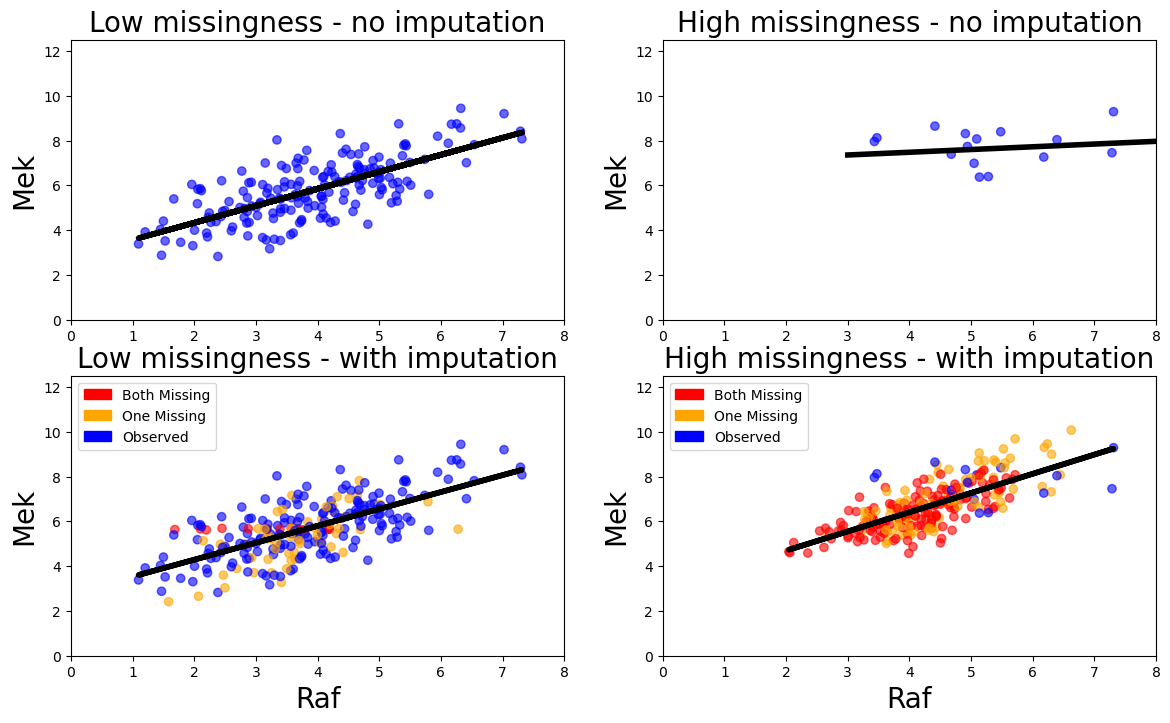

In [139]:
## Plot
fig, ax = plt.subplots(2, 2, figsize=(14,8))

colors1 = np.where((high_rep_protein_data["imp_Mek"] == True) & \
                   (high_rep_protein_data["imp_Raf"] == True), "Red", 
                  np.where((high_rep_protein_data["imp_Raf"] == True) | \
                           (high_rep_protein_data["imp_Mek"] == True), "Orange", "Blue"))

colors2 = np.where((high_missing_protein_data["imp_Mek"] == True) & \
                   (high_missing_protein_data["imp_Raf"] == True), "Red", 
                  np.where((high_missing_protein_data["imp_Raf"] == True) | \
                           (high_missing_protein_data["imp_Mek"] == True), "Orange", "Blue"))

ax[0,0].scatter(high_rep_protein_data["Raf"], high_rep_protein_data["Mek"], c=colors1, alpha=.6)
ax[0,0].plot(high_rep_protein_data["Raf"], 
           low_missing_lm.coef_[0]*high_rep_protein_data["Raf"] + low_missing_lm.intercept_[0], 
           color="black", lw=4)

ax[1,0].scatter(high_rep_protein_data["full_Raf"], high_rep_protein_data["full_Mek"], 
              c=colors1, alpha=.6)
ax[1,0].plot(high_rep_protein_data["full_Raf"], 
           low_missing_imp_lm.coef_[0]*high_rep_protein_data["full_Raf"] + low_missing_imp_lm.intercept_[0], 
           color="black", lw=4)

ax[0,1].scatter(high_missing_protein_data["Raf"], high_missing_protein_data["Mek"], 
              c=colors2, alpha=.6)
ax[0,1].plot(np.arange(3,9), 
           high_missing_lm.coef_[0]*np.arange(3,9) + high_missing_lm.intercept_[0], 
           color="black", lw=4)

ax[1,1].scatter(high_missing_protein_data["full_Raf"], high_missing_protein_data["full_Mek"], 
              c=colors2, alpha=.6)
ax[1,1].plot(high_missing_protein_data["full_Raf"], 
           high_missing_imp_lm.coef_[0]*high_missing_protein_data["full_Raf"] + high_missing_imp_lm.intercept_[0], 
           color="black", lw=4)

red_patch = mpatches.Patch(color='red', label='Both Missing')
orange_patch = mpatches.Patch(color='orange', label='One Missing')
blue_patch = mpatches.Patch(color='blue', label='Observed')

ax[1,1].legend(handles=[red_patch, orange_patch, blue_patch])
ax[1,0].legend(handles=[red_patch, orange_patch, blue_patch])

ax[0,0].set_xlim(0,8)
ax[1,1].set_xlim(0,8)
ax[0,1].set_xlim(0,8)
ax[1,0].set_xlim(0,8)
ax[0,0].set_ylim(0,12.5)
ax[1,1].set_ylim(0,12.5)
ax[0,1].set_ylim(0,12.5)
ax[1,0].set_ylim(0,12.5)

ax[0,0].set_title("Low missingness - no imputation", size=20)
ax[1,1].set_title("High missingness - with imputation", size=20)
ax[1,0].set_title("Low missingness - with imputation", size=20)
ax[0,1].set_title("High missingness - no imputation", size=20)

# ax[0,0].set_xlabel("Raf")
# ax[0,1].set_xlabel("Raf")
ax[1,1].set_xlabel("Raf", size=20)
ax[1,0].set_xlabel("Raf", size=20)

ax[0,0].set_ylabel("Mek", size=20)
ax[0,1].set_ylabel("Mek", size=20)
ax[1,1].set_ylabel("Mek", size=20)
ax[1,0].set_ylabel("Mek", size=20)
